In [1]:
import ssdeep
import pickle,os,sys,gc
import pandas as pd
# pd.set_option('display.max_columns', None)
import numpy as np
from tqdm import tqdm
from collections import Counter
import multiprocessing as mp
from multiprocessing import Process, Manager, Pool
import subprocess
from multiprocessing import Pool 
import time,datetime
from itertools import chain
import math
from operator import itemgetter
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.metrics import jaccard_score
from sklearn.metrics.pairwise import cosine_similarity
import functools
import itertools
import operator
from multiprocessing.dummy import Pool as ThreadPool
import os.path
from os import path


In [2]:
#  import sys,os
print(sys.executable)
print(sys.version)
print(sys.version_info)
import findspark
# os.environ['PYSPARK_PYTHON'] = '/usr/bin/python3' #'/home/antslab/anaconda3/bin/python'
findspark.init()
import pyspark
# from pyspark import SparkContext
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
from pyspark.sql import Row, SQLContext, SparkSession, window
from pyspark import SparkConf, SparkContext
# Import data types
from pyspark.sql.types import *
import  pyspark.sql.functions as F
conf = SparkConf()
# conf.set("spark.local.dir", "/mnt/ssd240g/data/Leo_Spark_Home/tmp")
conf.set("spark.executor.cores","12")
conf.setMaster("local[12]")
conf.set("spark.driver.memory","260g") #滿載165G/
conf.set("spark.executor.memory", "95g")
conf.set("spark.memory.offHeap.enabled","true")
conf.set("spark.memory.offHeap.size","85g")
conf.set("spark.driver.extraJavaOptions","-Xss80g")
conf.set("spark.driver.extraJavaOptions","-Xms80g")
# conf.set("spark.memory.storageFraction","0.2")
# conf.set("spark.driver.maxResultSize","0")
# conf.set("spark.sql.execution.arrow.pyspark.enabled", "true")
# conf.set("spark.sql.execution.arrow.enabled", "true")
conf.set("spark.kubernetes.pyspark.pythonVersion","3")
conf.set("spark.network.timeout","1000s")
conf.set("spark.sql.shuffle.partitions",100000)
conf.set("spark.driver.maxResultSize", "150g")

# spark = SparkSession.builder.appName("pcap_analyzer").config(conf=conf).getOrCreate() #pcap_analyzer pcapAnalyzer
spark = SparkSession.builder.master("local").appName("Test_spark").config(conf=conf).getOrCreate()
# spark.conf.set("spark.sql.execution.arrow.enabled", True)
spark.conf.set("spark.sql.debug.maxToStringFields", 290000)
spark.conf.set("spark.sql.hive.filesourcePartitionFileCacheSize",100*1024*1024*1024)

import databricks.koalas as ks
ks.options.display.max_rows = 20
ks.set_option('compute.max_rows', None)
# ks.set_option('compute.ops_on_diff_frames', True)
ks.set_option('compute.default_index_type', 'distributed')
print(ks.__version__,spark.version)
spark

/home/antslab/anaconda3/bin/python
3.7.9 (default, Aug 31 2020, 12:42:55) 
[GCC 7.3.0]
sys.version_info(major=3, minor=7, micro=9, releaselevel='final', serial=0)


1.4.0 3.0.0


In [4]:
isp='mi'
time = '20200111'
in_file = 'hdfs://192.168.50.123:8020/user/hdfs/parquet/'+str(time[:4])+'_'+str(time[4:6])+'_'+str(time[6:])+'/'+isp+'/session_parquet/'+str(time)+'_session.parquet'
df = ks.read_parquet(in_file)
df = df.to_pandas()
df

,session_time,session_time_list,session_duration,session_tt_packet,session_i_tt_packet,session_o_tt_packet,session_tt_frame_length,session_i_tt_frame_length,session_o_tt_frame_length,udp_tt_length,...,udp_dstport,country,domain,isp,frame_i_common_protocols,frame_o_common_protocols,frame_i_max_protocols,frame_o_max_protocols,tcp_i_payload_list,tcp_o_payload_list
0,1.610281e+09,[1610280612.733005],0.000000,1,0,1,89,NaN,89,27.0,...,48908.0,China,None,None,None,eth:ethertype:ip:icmp:ip:udp:data,None,eth:ethertype:ip:icmp:ip:udp:data,[],[]
1,1.610690e+09,"[1610689831.4813552, 1610689831.542274, 161068...",4.634416,27,0,27,8792,NaN,8792,NaN,...,NaN,Singapore,None,None,None,eth:ethertype:ip:tcp,None,eth:ethertype:ip:tcp:ssl:x509sat:x509sat:x509s...,[],[[24:NrPcoowcEakgIumDvUKS20dnEqVdoH/vIQIAyaWGi...
2,1.610799e+09,"[1610799252.4006565, 1610799252.4040897, 16107...",0.137543,3,0,3,180,NaN,180,NaN,...,NaN,Taiwan,sparqnet.net,None,None,eth:ethertype:ip:tcp,None,eth:ethertype:ip:tcp,[],[]
3,1.610776e+09,"[1610775871.2177103, 1610775871.2183242, 16107...",2.978323,4,0,4,252,NaN,252,NaN,...,NaN,Taiwan,sparqnet.net,None,None,eth:ethertype:ip:tcp,None,eth:ethertype:ip:tcp,[],[]
4,1.610846e+09,"[1610846115.3051786, 1610846115.3057935]",0.000615,2,0,2,120,NaN,120,NaN,...,NaN,Taiwan,sparqnet.net,None,None,eth:ethertype:ip:tcp,None,eth:ethertype:ip:tcp,[],[]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94489286284,1.610802e+09,"[1610802220.6701949, 1610802220.6707962]",0.000601,2,0,2,120,NaN,120,NaN,...,NaN,Taiwan,sparqnet.net,None,None,eth:ethertype:ip:tcp,None,eth:ethertype:ip:tcp,[],[]
94489286285,1.610782e+09,"[1610781743.941747, 1610781743.942369, 1610781...",0.217435,3,0,3,180,NaN,180,NaN,...,NaN,Taiwan,sparqnet.net,None,None,eth:ethertype:ip:tcp,None,eth:ethertype:ip:tcp,[],[]
94489286286,1.610725e+09,"[1610724822.5326068, 1610724822.5332117]",0.000605,2,0,2,120,NaN,120,NaN,...,NaN,Taiwan,sparqnet.net,None,None,eth:ethertype:ip:tcp,None,eth:ethertype:ip:tcp,[],[]
94489286287,1.610346e+09,"[1610346449.704983, 1610346449.705575]",0.000592,2,0,2,120,NaN,120,NaN,...,NaN,Taiwan,sparqnet.net,None,None,eth:ethertype:ip:tcp,None,eth:ethertype:ip:tcp,[],[]


In [11]:
df1 = df[df.tcp_o_payload_list.astype(str)!='[]']
df1.frame_o_max_protocols.value_counts() #mqtt、ocsp、mptcp、

eth:ethertype:ip:tcp:http:data                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

In [25]:
isp = 'mi' #All

in_file = np.nan
pickle_dir = np.nan
picture_dir = np.nan
df2 = ""
def create_orifinalDF(time):
    """
    GOAL: preprocess original df
    time: e.g., 20200101
    
    Return: df2
    """
    
    global in_file,pickle_dir,picture_dir #in file HDFS?
    in_file = 'hdfs://192.168.50.123:8020/user/hdfs/parquet/'+str(time[:4])+'_'+str(time[4:6])+'_'+str(time[6:])+'/'+isp+'/session_parquet/'+str(time)+'_session.parquet'
#     in_file = 'hdfs://192.168.50.200/user/hdfs/parquet/'+str(time[:4])+'_'+str(time[4:6])+'_'+str(time[6:])+'/'+isp+'/session_parquet/'+str(time)+'_session.parquet'
#     in_file = '/home/antslab/data_hdd4t/pcap_process/pcap_spark/'+str(time[:4])+'_'+str(time[4:6])+'_'+str(time[6:])+'/中華電信/parquet/2020_01_10_session_v7-2_hashpayload_time_size.parquet'  
    pickle_dir = '/home/antslab/NAS1_RAID6/pcap_inter/'+str(time[:4])+'_'+str(time[4:6])+'_'+str(time[6:])+'/'+isp+'/case_pickles/'
    picture_dir = '/home/antslab/NAS1_RAID6/pcap_inter/'+str(time[:4])+'_'+str(time[4:6])+'_'+str(time[6:])+'/'+isp+'/case_pictures/'
    
    if not os.path.exists(pickle_dir):
        os.makedirs(pickle_dir,exist_ok=True)
    if not os.path.exists(picture_dir):
        os.makedirs(picture_dir,exist_ok=True)    
    df = ks.read_parquet(in_file)
#     print(df.columns)
    df = df[['session_time','session_time_list','session_duration', 'session_i_tt_packet', 'session_o_tt_packet',
                 'session_i_tt_frame_length','session_o_tt_frame_length', 'udp_i_tt_length',
                 'udp_o_tt_length', 'udp_i_avg_length', 'udp_o_avg_length','icmp_i_avg_length', 'icmp_o_avg_length',
                 'icmp_i_tt_datagram_length','icmp_o_tt_datagram_length',
                 'tcp_i_tt_payload_length','tcp_o_tt_payload_length', 'tcp_i_avg_payload_length',
                 'tcp_o_avg_payload_length','ip_src', 'ip_dst','tcp_srcport', 'tcp_dstport', 'country','isp',
                 'domain', 'frame_i_max_protocols','frame_o_max_protocols', 'tcp_i_payload_list', 'tcp_o_payload_list'        
                ]]
     #篩選出有in bound payload的session
#     df1 = df[df.tcp_i_payload_list.astype(str)!='[]']
#     df1 = df1[(df1.udp_i_tt_length>0)|(df1.udp_i_avg_length>0)|(df1.icmp_i_avg_length>0)|
#             (df1.icmp_i_tt_datagram_length>0)|(df1.tcp_i_tt_payload_length>0)|(df1.tcp_i_avg_payload_length>0)]
    df1 = df
    df2 = df1[(df1.tcp_o_payload_list.astype(str)!='[]')]
#     df2 = df2[(df2.udp_o_tt_length>0)|(df2.udp_o_avg_length>0)|(df2.icmp_o_avg_length>0)|
#             (df2.icmp_o_tt_datagram_length>0)|(df2.tcp_o_tt_payload_length>0)|(df2.tcp_o_avg_payload_length>0)]
#     df2 = df2[(df2.domain != 'googlebot.com')|(df2.isp!='Googlebot')] #
    gc.collect()
    df2 = df2.to_pandas() #記憶體可能會不夠?
#     print(time,"=> 所有protocol總和中，1.原本的session總數:",len(df)," 2.in-bound具有payload的session總數:",len(df1)," 3.in-與out-bound都具有payload的session總數(最終拿來進行分群的sessions):",len(df2))

    #     print(df2.frame_i_max_protocols.value_counts().head(60))
#     print(df2.frame_o_max_protocols.value_counts().head(60))
#     print(df2.domain.value_counts().head(60))
#     print(df2.isp.value_counts().head(60))
#     protocol_name = 'tds'
#     df2_tds = df2[(df2.frame_i_max_protocols.str.contains(protocol_name))&(df2.frame_o_max_protocols.str.contains(protocol_name))]
#     print(time,'TDS sessions數量:',len(df2_tds),'TDS占所有protocols之sessions比例:',len(df2_tds)/len(df))
    return df2,pickle_dir,picture_dir#,df2_tds

### Function

In [38]:
#記得改&
def prepare_df(df2,protocol_name='http',split="size",loner=False):
    protocol_name = str(protocol_name).lower()
    '''
    df2: filterout no payload's all sessions df
    protocol_name: what TCP protocol string would be contained e.g., smb,http,tds...
    loner: 用來檢查不同天相同protocol的分群
    
    return1: protocol original dataframe (session-based)
    return2: protocol payload dataframe (packet-based)
    '''
    def sort_fn(data):
        '''
        sort by time: itemgetter(1)
        sort by size: itemgetter(2)
        '''
        if split=='size':
            try:
                return sorted(data,key=itemgetter(2))
            except IndexError:
                return sorted(data,key=itemgetter(1))
        elif split == 'time':
            return sorted(data,key=itemgetter(1))
                    
    def split_col_len(session):
        '''
        input: list(session) of lists(packets) =>tuple=(hash,time)

        Return1: list of ssdeep length
        Return2: list of session's packets hashes
        '''
    #     for session in payload_li:
#         packet_payload = []
        packet_len = []
        for packet in session:
            ssdeep_hash = packet[0]
    #         packet_payload.append(ssdeep_hash)
            packet_len.append(ssdeep_hash.split(':')[0])
        return packet_len#,packet_payload

    def split_col_hash(session):
        '''
        input: list(session) of lists(packets) =>tuple=(hash,time)

        Return1: list of ssdeep length
        Return2: list of session's packets hashes
        '''
    #     for session in payload_li:
        packet_payload = []
#         packet_len = []
        for packet in session:
            ssdeep_hash = packet[0]
            packet_payload.append(ssdeep_hash)
    #         packet_len.append(ssdeep_hash.split(':')[0])
        return packet_payload
    if not loner: ##改!!
        df2_protocol = df2[df2.frame_o_max_protocols.str.contains(protocol_name)]
#         df2_protocol = df2[(df2.frame_i_max_protocols.str.contains(protocol_name))&(df2.frame_o_max_protocols.str.contains(protocol_name))]
    else:
        df2_protocol = df2
    df2_protocol_payload = df2_protocol[['tcp_o_payload_list']]
    df2_protocol_payload['tcp_o_payload_list'] = df2_protocol_payload.tcp_o_payload_list.apply(sort_fn) #map
    df2_protocol_payload['size'] = df2_protocol_payload.tcp_o_payload_list.map(split_col_len) #,df2_protocol_payload['hash']
    df2_protocol_payload['hash'] = df2_protocol_payload.tcp_o_payload_list.map(split_col_hash)
    L_size = [x if isinstance(x, list) else [x] for x in df2_protocol_payload['size']]
    L_hash = [x if isinstance(x, list) else [x] for x in df2_protocol_payload['hash']]
    df2_protocol_payload = pd.DataFrame({
        'idx':df2_protocol_payload.index.values.repeat([len(x) for x in L_size]),
        'size':list(chain.from_iterable(L_size)),
        'hash':list(chain.from_iterable(L_hash))
        })
    # df2_protocol_payload['idx'] = 
    df2_protocol_payload['size'] = df2_protocol_payload['size'].astype(int)
    if not loner:
        return df2_protocol, df2_protocol_payload
    else:
        return df2_protocol_payload

In [27]:
def similarity_compare(df2_protocol,df2_protocol_payload,ori_protocol=None,ori_protocol_payload=None,thr=0,thr2=10,loner=False): #40
    '''
    GOAL: compare with timestamp's q1,q2,q3 to similar size packet. Calculate max/mean value for score.
    df2_protocol: protocol original dataframe (session-based)
    df2_protocol_payload: protocol payload dataframe (packet-based)
    loner:需指派ori_protocol、ori_protocol_payload
    
    Return: dictionary with each cluster 
    '''
    def ssdeep_compare(target_hash,candidate_df):
        '''
        Input1: string of hash
        Input2: dataframe of candidate
        '''
        def compare(candidate_hash):
            return ssdeep.compare(target_hash,candidate_hash)
        return candidate_df.hash.map(compare)
    big_dict_protocol = {}
    big_dict_protocol_score = {}
#     big_dict_protocol2 = {} #test
    used_idx_li = []
    all_scores = [] #test2
    for idx in df2_protocol.index:
        if idx in used_idx_li:
            continue
        target = df2_protocol_payload[df2_protocol_payload.idx == idx]
        target = target.reset_index(drop=True)
        t_len = len(target)
        q1 = int(t_len*0.25)
        q2 = int(t_len*0.5)
        t_q1 = target.iloc[q1,-1]
        if not loner:
            candidate = df2_protocol_payload[df2_protocol_payload.idx!=idx]
            candidate = candidate[~candidate.idx.isin(used_idx_li)] #candidat不可重複分群
        else:
            t_ip = df2_protocol[df2_protocol.index == idx].ip_src.values[0]
            candidate_idx = ori_protocol[ori_protocol.ip_src == t_ip].index.tolist()
            candidate = ori_protocol_payload[ori_protocol_payload.idx.isin(candidate_idx)] #可重複分群?
        
        candidate['idx'] = candidate.idx.astype(str)
#         candidate_q1 = candidate[candidate['size']==target.iloc[q1,-2]] #rule
        candidate['q1'] = ssdeep_compare(t_q1,candidate) #rule:candidate_q1
        if q2 != q1:
            t_q2 = target.iloc[q2,-1]
            q3 = int(t_len*0.75)
#             candidate_q2 = candidate[candidate['size']==target.iloc[q2,-2]] #rule
            candidate['q2'] = ssdeep_compare(t_q2,candidate) #rule:candidate_q2
            if q3 != q2:
                t_q3 = target.iloc[q3,-1]
#                 candidate_q3 = candidate[candidate['size']==target.iloc[q3,-2]] #rule
                candidate['q3'] = ssdeep_compare(t_q3,candidate) #rule:candidate_q3
                if t_len>4:
#                     t_min = target.iloc[0,-1] 
#                     candidate['min'] = ssdeep_compare(t_min,candidate)
                    t_max = target.iloc[-1,-1]
                    candidate['max'] = ssdeep_compare(t_max,candidate)
                    gc.collect()
                    
        candidate = candidate.drop(['size','hash'],axis=1)
        candidate['score'] = candidate.mean(axis=1) #max
        score_li = candidate.score.tolist() #test2
        candidate = candidate[candidate.score>thr] #相似度分數，數字越小速度愈快、數字越大越多群
        candidate['idx'] = candidate.idx.astype(int)
#         candidate2 = candidate[candidate.score<thr2] #test
        idx_li = list(set(candidate.idx.tolist()))
#         idx_li2 = list(set(candidate2.idx.tolist())) #test
        all_scores.extend(score_li) #test2
        if len(idx_li)>0:
            
            used_idx_li.extend(idx_li)
            used_idx_li.append(idx)
            if not loner:
                big_dict_protocol[idx] = idx_li
                big_dict_protocol_score[idx] = candidate.score.tolist()
            else:
                big_dict_protocol[t_ip+'_'+str(idx)] = idx_li
                big_dict_protocol_score[t_ip+'_'+str(idx)] = candidate.score.tolist()                
#         if len(idx_li2)>0: #test
#             big_dict_protocol2[idx] = idx_li2 # test
    return big_dict_protocol,sorted(list(set(df2_protocol.index)-set(used_idx_li))),all_scores,big_dict_protocol_score #test

In [28]:
def write2pkl(df2_protocol,big_dict,cluster_key,case_id,path=pickle_dir):
    '''
    GOAL: output 3-tuple to draw time diagram
    df2_protocol: original dataframe session-based
    big_dict: big_dict_protocol
    cluster_key: print by find_cluster function
    case_id: user defined to identify
    '''
    cluster_key = int(cluster_key)
#     print(big_dict[cluster_key])
    temp_li = big_dict[cluster_key][:]
#     print(temp_li)
    temp_li.append(cluster_key) #最後一個session才是key (target)，其他人(candidates)都是跟他(target)比
#     print(temp_li)
#     temp_li = temp_li2[:]
    case_diagram = df2_protocol.loc[list(set(temp_li))]
    time_lists = case_diagram.session_time_list.tolist()
    time_lists = [list(x) for x in time_lists]
    ips = case_diagram.ip_src.tolist()
    countries = case_diagram.country.tolist()
#     print('Unique Country#:',len(set(countries)),"Unique IP#:",len(set(ips)),'Session#:',len(time_lists))
    # pickle_dir = '/home/antslab/spark_data/pcap_inter/2020_01_10/中華電信/case_pickles/'
    pickle.dump(obj=(time_lists,ips,countries),file=open(path+'case#'+str(case_id)+'_threetuples.pkl','wb'))        


In [29]:
def find_cluster(big_dict,idx):
    '''
    big_dict: big_dict_protocol
    idx: which idx want to find
    Return cluster id (big_dict"s key number')
    '''
    idx = int(idx)
    try:
        big_dict[idx] #KeyError
        return idx
    except KeyError:
        for k,v in big_dict.items():
            if idx in v:
                return k
                break

In [30]:
def cluster_stat(protocol_big_dict,protocol_df,proto,date,picture_dir,drawlog=False):
    """
    GOAL: output statistic of certain protocol
    input1: dict from similarity_compare
    inpit2: df from prepare_df
    """
    
    all_nums = []
    clus_id = []
    # all_num = 0
    for k,v in protocol_big_dict.items():
    #     all_nums.extend(v)
        all_nums.append(len(v))
        clus_id.append(k)
    #     all_num +=len(v)
    clus_num = len(all_nums)
    print("原本總共sessions#:",len(protocol_df))
    print("共有#sessions可分群:",sum(all_nums)+clus_num,"共有#lonerSessions:",len(protocol_df)-(sum(all_nums)+clus_num))
    print("可分為#群:",clus_num)
#     print(sum(all_nums)+len(all_nums),len(protocol_df)-(sum(all_nums)+len(all_nums)),len(protocol_df))
    protocol_stat_df = pd.DataFrame(all_nums,index=clus_id)
    protocol_stat_df[0] = protocol_stat_df[0]+1
    print("前五大的cluster key與對應之群集大小\n",protocol_stat_df[0].nlargest(5))
    print(protocol_stat_df.describe())
    protocol_stat_df  = pd.DataFrame(all_nums,index=[x for x in range(len(all_nums))])
    protocol_stat_df.hist(bins=100)
    plt.savefig(picture_dir+str(proto)+'_'+str(date)+'_clustersize_hist'+'.png', dpi=300, format='png')
    
    temp = dict(Counter(all_nums))
    temp = {k: v for k, v in sorted(temp.items(), key=lambda item: item[0])}
#     temp = sorted(all_nums,reverse=True)
    x_axis = [k for k in temp.keys()] #群中所含的數量
    y_axis = [v for v in temp.values()] #該數量共有幾群為此
    plt.figure(figsize=(30,20),dpi=300,linewidth = 1) # 圖片大小、折線寬度
    plt.plot(x_axis,y_axis,'o-',color = 'b', label=proto) #折現的型態、折現的顏色
#     plt.title(, x=0.5, y=1.03)
    plt.figtext(.5,.9,str(date)+" "+str(proto)+" cluster# of cluster's size",fontsize=30,ha='center')
#     plt.xticks(fontsize=20)
#     plt.yticks(fontsize=20)
    plt.xlabel("cluster size", fontsize=25, labelpad = 15)
    plt.ylabel("cluster #", fontsize=25, labelpad = 20)
    # plt.ylim(0, 2500)
    # plt.legend(loc = "best", fontsize=20)
    plt.savefig(picture_dir+str(proto)+'_'+str(date)+'_clusternumber_line'+'.png', dpi=300, format='png')
#     plt.show()    
    
#log diagram
    fig, ax = plt.subplots()
    ax.set_yscale('log')
    protocol_stat_df.hist(ax=ax, bins=100, bottom=0.1)
    plt.savefig(picture_dir+str(proto)+'_'+str(date)+'_clustersize_hist_log'+'.png', dpi=300, format='png')
    
    return len(protocol_df)-(sum(all_nums)+clus_num),protocol_stat_df.describe()

In [31]:
def cluster_rep_hash(proto_big_dict,proto_df_payload,proto_df,proto_loners,knee_point,date='0110',protocol='http'):
    '''
    GOAL: create each cluster's representaion ssdeep hash
    proto_df_payload: from prepare_df() function
    proto_big_dict: from similarity_compare() function
    proto_loners: loner idx list
    knee_point: from get_small_cluster() function
    date & protocol: user_defined cluster name
    
    Return: dict[cluster_name]: ssdeep hash
    '''
    upgma_dict = {}
    for key,value in proto_big_dict.items(): #cluster rep ssdeep
        target = proto_df_payload[proto_df_payload.idx == key]
        target = target.reset_index(drop=True)
        t_len = len(target)
        q2 = int(t_len*0.5)
        q2_hash = target.iloc[q2,-1]
        country = proto_df.loc[key,'country']
        ip = proto_df.loc[key,'ip_src']
        domain = proto_df.loc[key,'domain']
        if len(value)>knee_point:
            upgma_dict[str(protocol)+'_'+str(key)+'_'+str(date)+'_'+str(country)+'_'+str(domain)+'_'+str(ip)] = q2_hash
        else:
            upgma_dict[str(protocol)+'_S_'+str(key)+'_'+str(date)+'_'+str(country)+'_'+str(domain)+'_'+str(ip)] = q2_hash
    for key in proto_loners: #loner ssdeep
        target = proto_df_payload[proto_df_payload.idx == key]
        target = target.reset_index(drop=True)
        t_len = len(target)
        q2 = int(t_len*0.5)
        q2_hash = target.iloc[q2,-1]
        country = proto_df.loc[key,'country']
        ip = proto_df.loc[key,'ip_src']
        domain = proto_df.loc[key,'domain']
        upgma_dict[str(protocol)+'_L_'+str(key)+'_'+str(date)+'_'+str(country)+'_'+str(domain)+'_'+str(ip)] = q2_hash
    return upgma_dict



def pair_wise_score(upgma_dict):
    '''
    GOAL: calculate distance matrix by calculating paire-wise similarity score. 
    and pick upper triangle convert to list
    Input: from cluster_rep_hash() function
    ['cluster']: name
    ['ssdeep']: cluster's representation hash
    
    Return: df=>['c_ssdeep_li']:the hashes list compare to, ['score']:list of distances (upper-triangle, exclude self)
    '''
    def compare(target_hash,candidate_hash_li):
        score_li = []
        for c_hash in candidate_hash_li:
            score_li.append(100-ssdeep.compare(target_hash,c_hash)) #相似度滿分100，轉換成距離最近0
        return score_li
    used_idx = []
    def create_hash_li(t_hash):
        idx_set = set(upgma_df[upgma_df.ssdeep == t_hash].index)#[0]
        same_hash_li = sorted(list(idx_set - set(used_idx)))
        idx = same_hash_li[0]
        used_idx.append(idx)
        return upgma_df.loc[idx+1:]['ssdeep'].tolist()
    upgma_df = pd.DataFrame(upgma_dict.items(),columns=['cluster','ssdeep'])
    upgma_df['c_ssdeep_li'] = upgma_df.ssdeep.map(create_hash_li)
    upgma_df['score'] = upgma_df.apply(lambda x: compare(x.ssdeep, x.c_ssdeep_li), axis=1)
    return upgma_df



def draw_upgma(upgma_df,picture_dir=picture_dir,name='upgma'):
    '''
    GOAL: using upper triangle's distance to draw upgma
    Input: from pair_wise_score() function
    Output: diagram of UPGMA、Z info
    '''
    if not os.path.exists(picture_dir):
        os.makedirs(picture_dir,exist_ok=True) 
    score_li = upgma_df['score'].tolist()
    score_li = list(filter(None, score_li))
    score_li = sum(score_li,[])
    Z = linkage(score_li, 'average')
    fig = plt.figure(figsize=(60, 24)) #(25,10) #(5,2)
    # plt.savefig(fig)
    dn = dendrogram(Z,labels=upgma_df.cluster.tolist())
    plt.savefig(picture_dir+str(name)+'.png', dpi=600, format='png', bbox_inches='tight')
    return dn,Z

In [32]:
def knee_point(length_li,proto='http',date='20200110',k=100):
    """
    每個list值所包含數量的變化量，也就是點的密集度變化量 (並非list自己本身值的變化量)
    length_li: 長度的list
    k: slope topK's knee points
    Return dict format (key is the answer)
    """
    length_dict = dict(Counter(length_li))
    sorted_dict = {k: v for k, v in sorted(length_dict.items(), key=lambda x: x[1])}
    all_items_num = sum(list(length_dict.values()))
#     for item in sorted_dict.items():
    all_keys = list(sorted_dict.keys())
    all_values = list(sorted_dict.values())
    slope_li = []
    for i in range(len(sorted_dict)):
        length1 = all_keys[i]
        try:
            length2 = all_keys[i+1]
        except IndexError:
            break
        value1 = sum(all_values[:i+1])
        value2 = sum(all_values[:i+2])
        slope = ((value2-value1)/all_items_num)/(length2-length1)
        slope_li.append(slope)
    change_rate_li = []
    for i in range(len(slope_li)):
        try:
            slope1 = slope_li[i]
            slope2 = slope_li[i+1]
        except IndexError:
            break
        change_rate_li.append(abs(slope2-slope1)) #陡變緩或是緩變陡的都一起算
    idx_li = sorted(range(len(change_rate_li)), key=lambda i: change_rate_li[i], reverse=True)[:k]
    return_dict = {}
    for idx in idx_li:
        return_dict[all_keys[idx+1]] = change_rate_li[idx]
    ##畫圖可再自行修改
    temp = sorted(length_li,reverse=True)
    x_axis = [x for x in range(len(temp))] #隨便給個編號當成X軸
    plt.figure(figsize=(30,20),dpi=300,linewidth = 1) # 圖片大小、折線寬度
    plt.plot(x_axis,temp,'o-',color = 'b', label=proto) #折現的型態、折現的顏色
#     plt.title(, x=0.5, y=1.03)
    plt.figtext(.5,.9,str(date)+" "+str(proto)+" clusters' size",fontsize=30,ha='center')
#     plt.xticks(fontsize=20)
#     plt.yticks(fontsize=20)
#     plt.xlabel("cluster ID", fontsize=25, labelpad = 15)
#     plt.ylabel("session #", fontsize=25, labelpad = 20)
    # plt.ylim(0, 2500)
    # plt.legend(loc = "best", fontsize=20)
    plt.savefig(picture_dir+str(proto)+'_'+str(date)+'_clustersize_line'+'.png', dpi=300, format='png')
#     plt.show()
    return pd.DataFrame.from_dict(return_dict,orient='index',columns=['knee_slope'])

In [33]:
def get_small_cluster(proto_big_dict,proto_loner_num,q1_num,proto,date):
    '''
    proto_big_dict: big dict from similarity_compare() func. (用以獲得各群的member數量)
    proto_loner_num: the protocol's loner numbers
    q1_num: 25%'s members# from
    
    Return: how many lesser is small cluster to deal as loner  (dict's member num)
    '''
    proto_dict_len = {}
    for k,v in proto_big_dict.items():
        proto_dict_len[k] = len(v)+1
    temp = list(proto_dict_len.values())
    for i in range(proto_loner_num):
        temp.append(1)
    temp = sorted(temp,reverse=True)
    temp_df = knee_point(temp,proto=proto,date=date)
    temp_score = temp_df.index.tolist()
    try:
        if temp_df.index[0] <q1_num:
            return temp_df.index[0]-1
        else:
            for score in temp_score:
                if score <q1_num:
                    return int(score)-1 #往後找其他knee point要小於q1
            return 0 #都不合<q1
    except IndexError:
        return 0 #群太少人太小分不出knee point

In [34]:
def case_cluster_info(protocol_loners,protocol_big_dict,protocol_df,pickle_dir,proto='http',df2=df2):
    '''
    GOAL: output loner & each cluster's three tuples pickles.
    save file in pickle_dir+protol/ dir
    
    protocol_loners: from similarity_compare() func.
    protocol_big_dict: from similarity_compare() func.
    proto: now using what kind of protocol
    df2: payload whole df
    '''
    loner_df = df2.loc[protocol_loners]
    time_lists = loner_df.session_time_list.tolist()
    time_lists = [list(x) for x in time_lists]
    ips = loner_df.ip_src.tolist()
    countries = loner_df.country.tolist()
    pkl_dir = pickle_dir+proto+'/'
    if not os.path.exists(pkl_dir):
        os.makedirs(pkl_dir)
    pickle.dump(obj=(time_lists,ips,countries),file=open(pkl_dir+'case#loners'+'_threetuples.pkl','wb'))
    #cluster
    protocol_big_dict = {k: v for k, v in sorted(protocol_big_dict.items(), key=lambda item: len(item[1]),reverse=True)}
    for i,k in enumerate(protocol_big_dict.keys()):
        write2pkl(protocol_df,protocol_big_dict,k,str(i+1)+"_"+str(k),path=pkl_dir)
    return protocol_big_dict

run all protocols needed

In [35]:
protocols_need = ['ssh','mysql','ftp','telnet','smb','http','pop','smtp','sip','imap','rpc',
                  'mqtt','ocsp','mptcp']
# protocols_need = ['ssh']
# protocols_need = ['smb','rpc','imap','pop','smtp','mysql','sip','telnet','ftp','ssh','http'] #ori worked
protocols_tuples = []

In [36]:
def run_all(proto,date,df2,pickle_dir,picture_dir): 
    '''
    proto: protocol contains for e.g., http
    date: day number e.g.,20200110
    '''
    proto_df, proto_df_payload = prepare_df(df2,proto)
    proto_big_dict,proto_loners,proto_score,proto_cluster_score_dict = similarity_compare(proto_df,proto_df_payload,thr=0)
    print("==========",str(proto)+" clusters ==========")
    try:
        proto_loner_num,stat_df = cluster_stat(proto_big_dict,proto_df,proto=proto,picture_dir=picture_dir,date=date)
        proto_big_dict = case_cluster_info(proto_loners,proto_big_dict,proto_df,pickle_dir=pickle_dir,proto=proto,df2=df2)
        small_clu_num = get_small_cluster(proto_big_dict,proto_loner_num,stat_df.loc['25%'].values[0],proto,date)
#         print("===",str(proto),"loner threshold [small cluster / knee point]:",small_clu_num+1,"(include) ===")
        proto_upgma_dict = cluster_rep_hash(proto_big_dict,proto_df_payload,proto_df,proto_loners,knee_point=small_clu_num,date=date,protocol=proto)
        pickle.dump(obj=proto_upgma_dict,file=open(pickle_dir+str(proto)+'_upgma_dict_'+str(date)+'.pkl','wb'))
        gc.collect()
        pickle.dump(obj=(proto_df, proto_df_payload,proto_big_dict,proto_loners,proto_score,proto_cluster_score_dict,
                        proto_upgma_dict,stat_df),file=open(pickle_dir+str(date)+'_'+str(proto)+'_all.pkl','wb'))
    except KeyError:
        print("!!!Didn't save:",date,proto,"!!!")
#     plt.clf()
    plt.close()
    gc.collect()
#         return ()
#     return (proto_df, proto_df_payload,proto_big_dict,proto_loners)

In [43]:
isp

'mi'

===Running date: mi 20200111 ===
20200111 Done df2.
========== smb clusters ==========
原本總共sessions#: 0
========== ftp clusters ==========
原本總共sessions#: 0
========== ssh clusters ==========
原本總共sessions#: 0
共有#sessions可分群: 0 共有#lonerSessions: 0
可分為#群: 0
共有#sessions可分群:共有#sessions可分群:!!!Didn't save: 20200111 ssh !!!
========== mysql clusters ==========
原本總共sessions#: 0
共有#sessions可分群: 0 共有#lonerSessions: 0
可分為#群: 0  
0 共有#lonerSessions: 0
可分為#群: 0
!!!Didn't save: 20200111 smb!!!Didn't save: 20200111 mysql !!!
 !!!
0 共有#lonerSessions:==========  pop clusters ==========
0
原本總共sessions#:可分為#群:  0
共有#sessions可分群: 0 共有#lonerSessions: 0
可分為#群: 0
!!!Didn't save: 20200111 pop !!!
0
========== smtp clusters ==========
原本總共sessions#: 0
共有#sessions可分群: 0 共有#lonerSessions: 0
可分為#群: 0
!!!Didn't save: 20200111 smtp !!!
!!!Didn't save: 20200111 ftp !!!
========== telnet clusters ==================== sip clusters ==========
原本總共sessions#: 0
共有#sessions可分群: 0 共有#lonerSessions: 0
可分為#群: 0
!!!Didn't save

/home/antslab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/antslab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/antslab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: htt

 共有#lonerSessions: 0
可分為#群: 0
!!!Didn't save: 20200111 telnet !!!


/home/antslab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/antslab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/antslab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: htt

========== ocsp clusters ==========
原本總共sessions#: 24
共有#sessions可分群: 23 共有#lonerSessions: 1
可分為#群: 2
前五大的cluster key與對應之群集大小
 528           19
8589935374     4
Name: 0, dtype: int64
               0
count   2.000000
mean   11.500000
std    10.606602
min     4.000000
25%     7.750000
50%    11.500000
75%    15.250000
max    19.000000
========== http clusters ==========
原本總共sessions#: 5532
共有#sessions可分群: 5531 共有#lonerSessions: 1
可分為#群: 10
前五大的cluster key與對應之群集大小
 6     4380
1      541
3      209
22     180
9      177
Name: 0, dtype: int64
                 0
count    10.000000
mean    553.100000
std    1355.073631
min       2.000000
25%       5.750000
50%     100.500000
75%     201.750000
max    4380.000000
========== mqtt clusters ==========
原本總共sessions#: 490
共有#sessions可分群: 490 共有#lonerSessions: 0
可分為#群: 1
前五大的cluster key與對應之群集大小
 31    490
Name: 0, dtype: int64
           0
count    1.0
mean   490.0
std      NaN
min    490.0
25%    490.0
50%    490.0
75%    490.0
max    490.0


/home/antslab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/antslab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/antslab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: htt

========== mptcp clusters ==========
原本總共sessions#: 5
共有#sessions可分群: 5 共有#lonerSessions: 0
可分為#群: 1
前五大的cluster key與對應之群集大小
 414    5
Name: 0, dtype: int64
         0
count  1.0
mean   5.0
std    NaN
min    5.0
25%    5.0
50%    5.0
75%    5.0
max    5.0
CPU times: user 24.2 s, sys: 1.23 s, total: 25.5 s
Wall time: 14.7 s


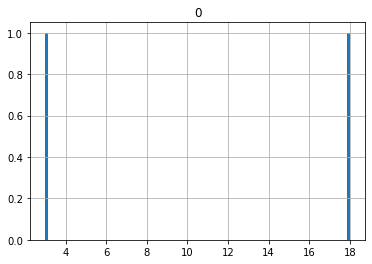

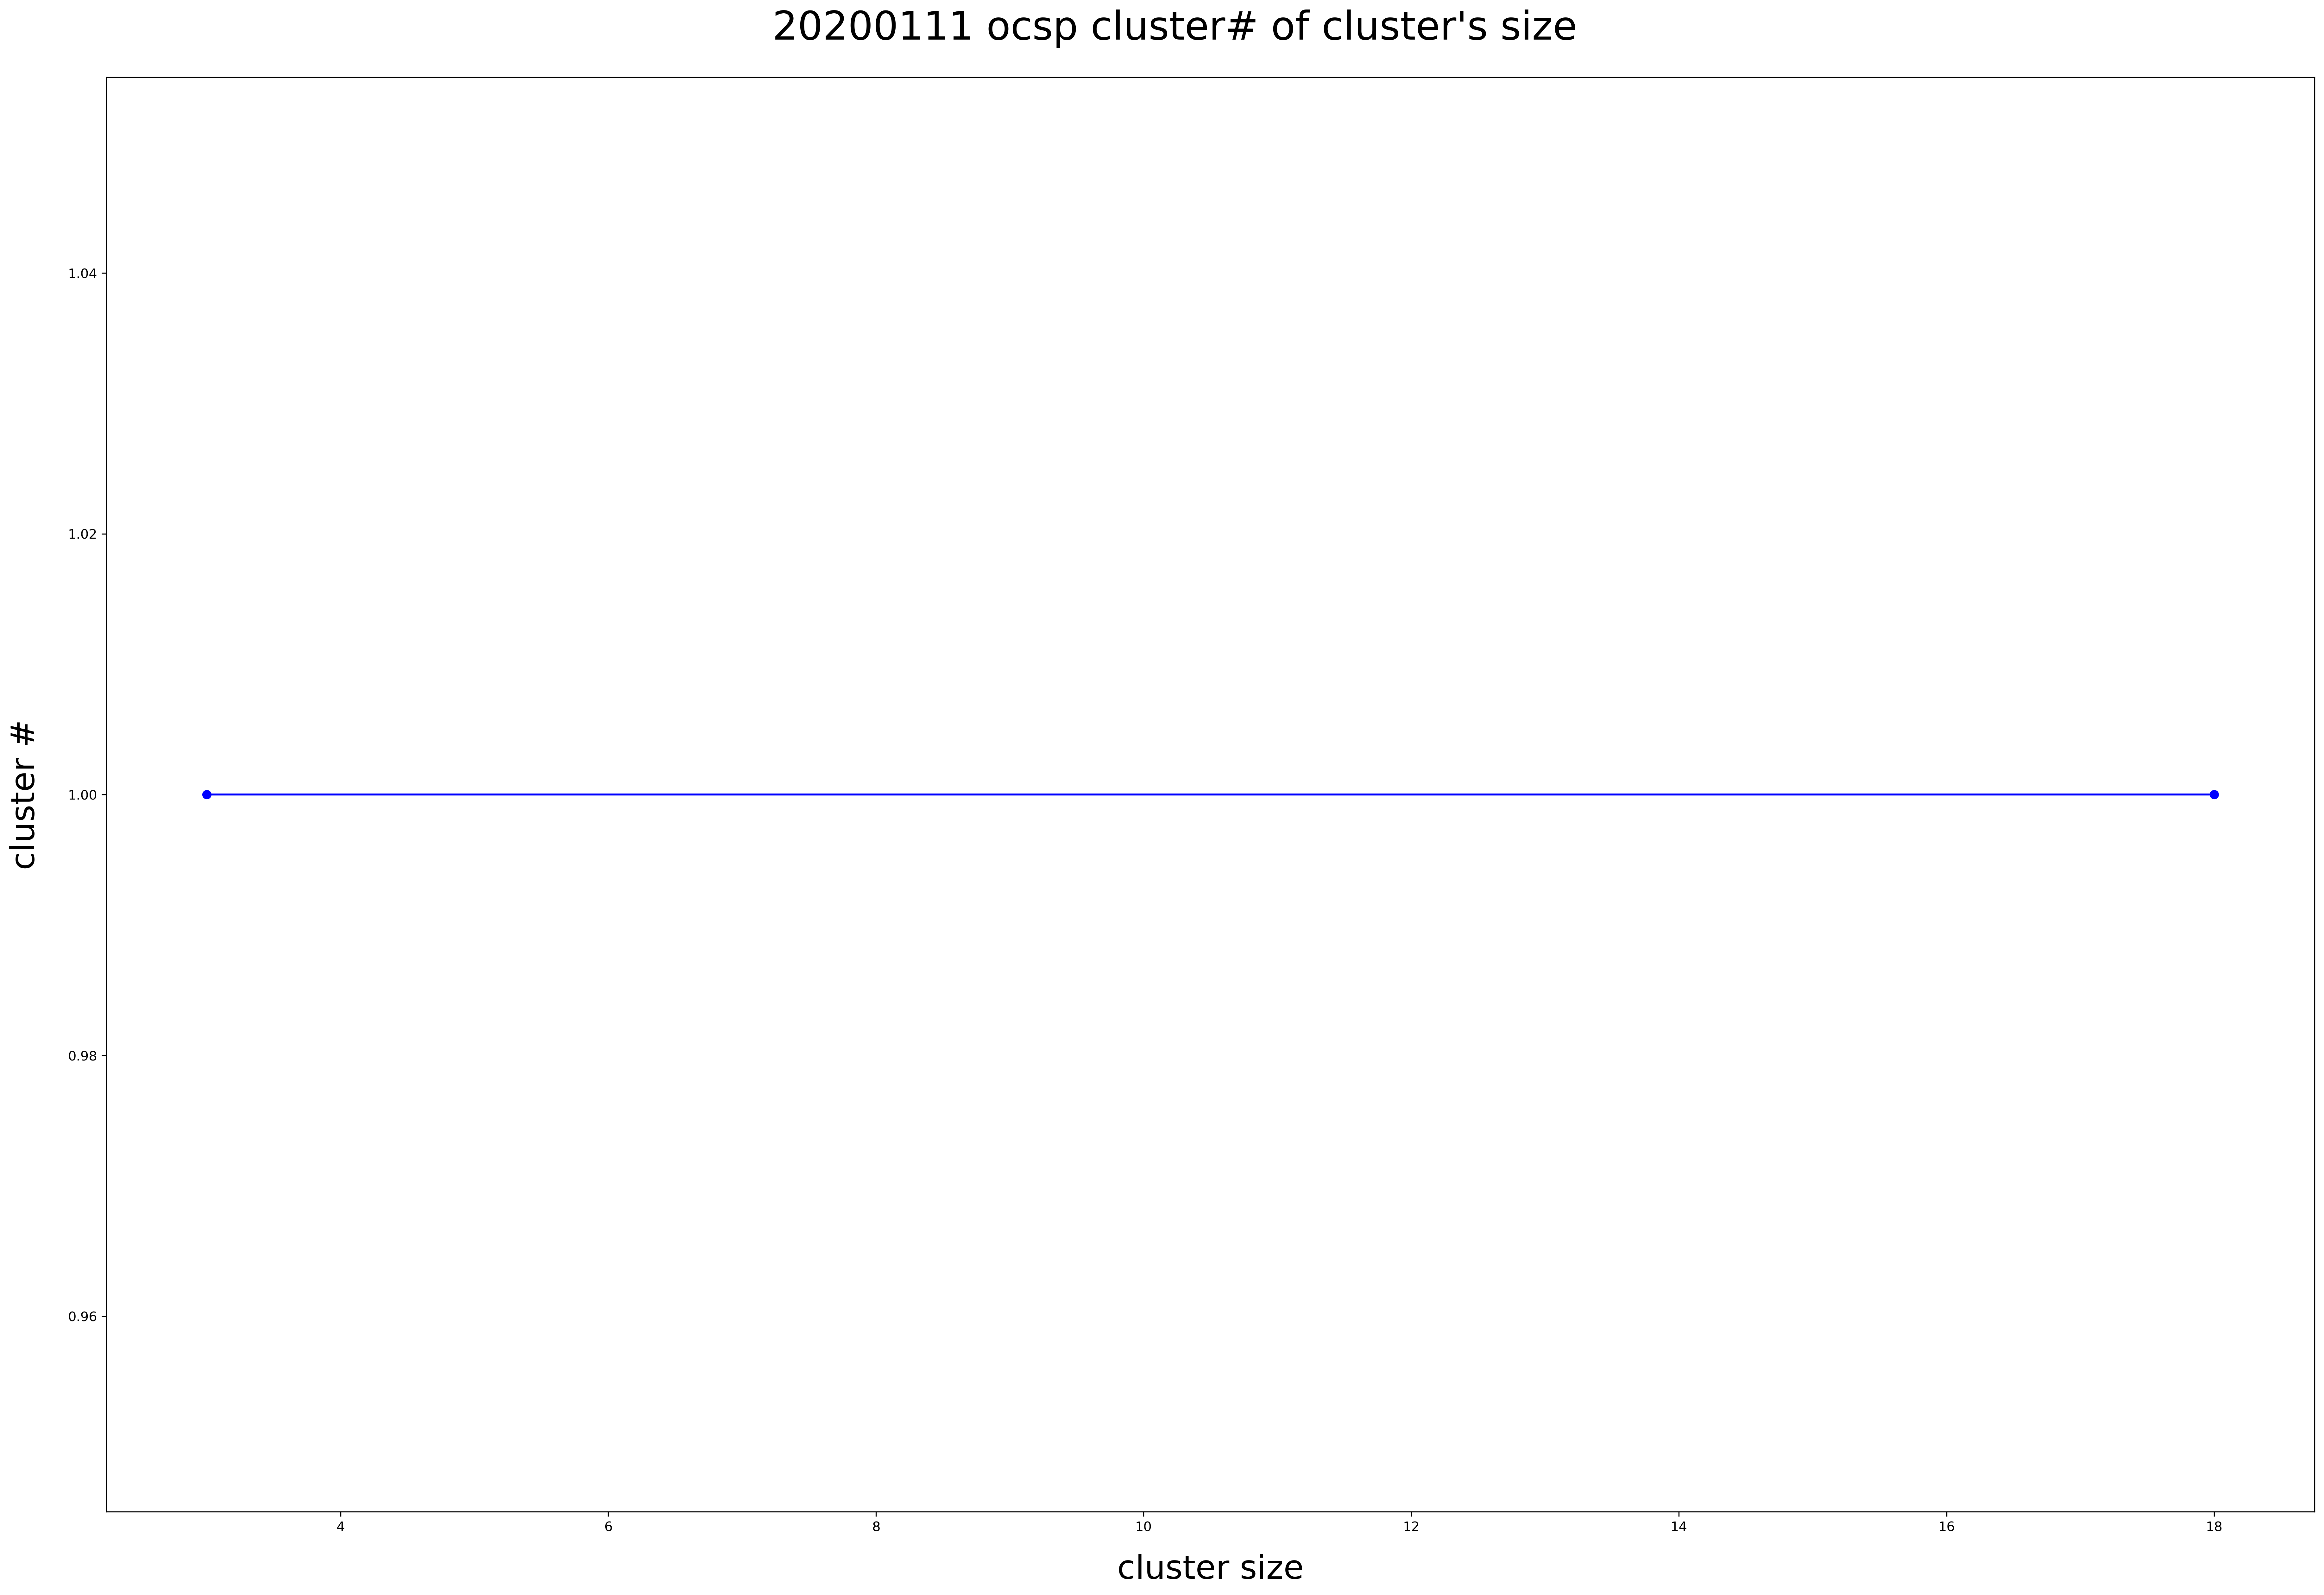

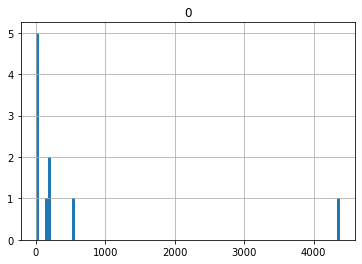

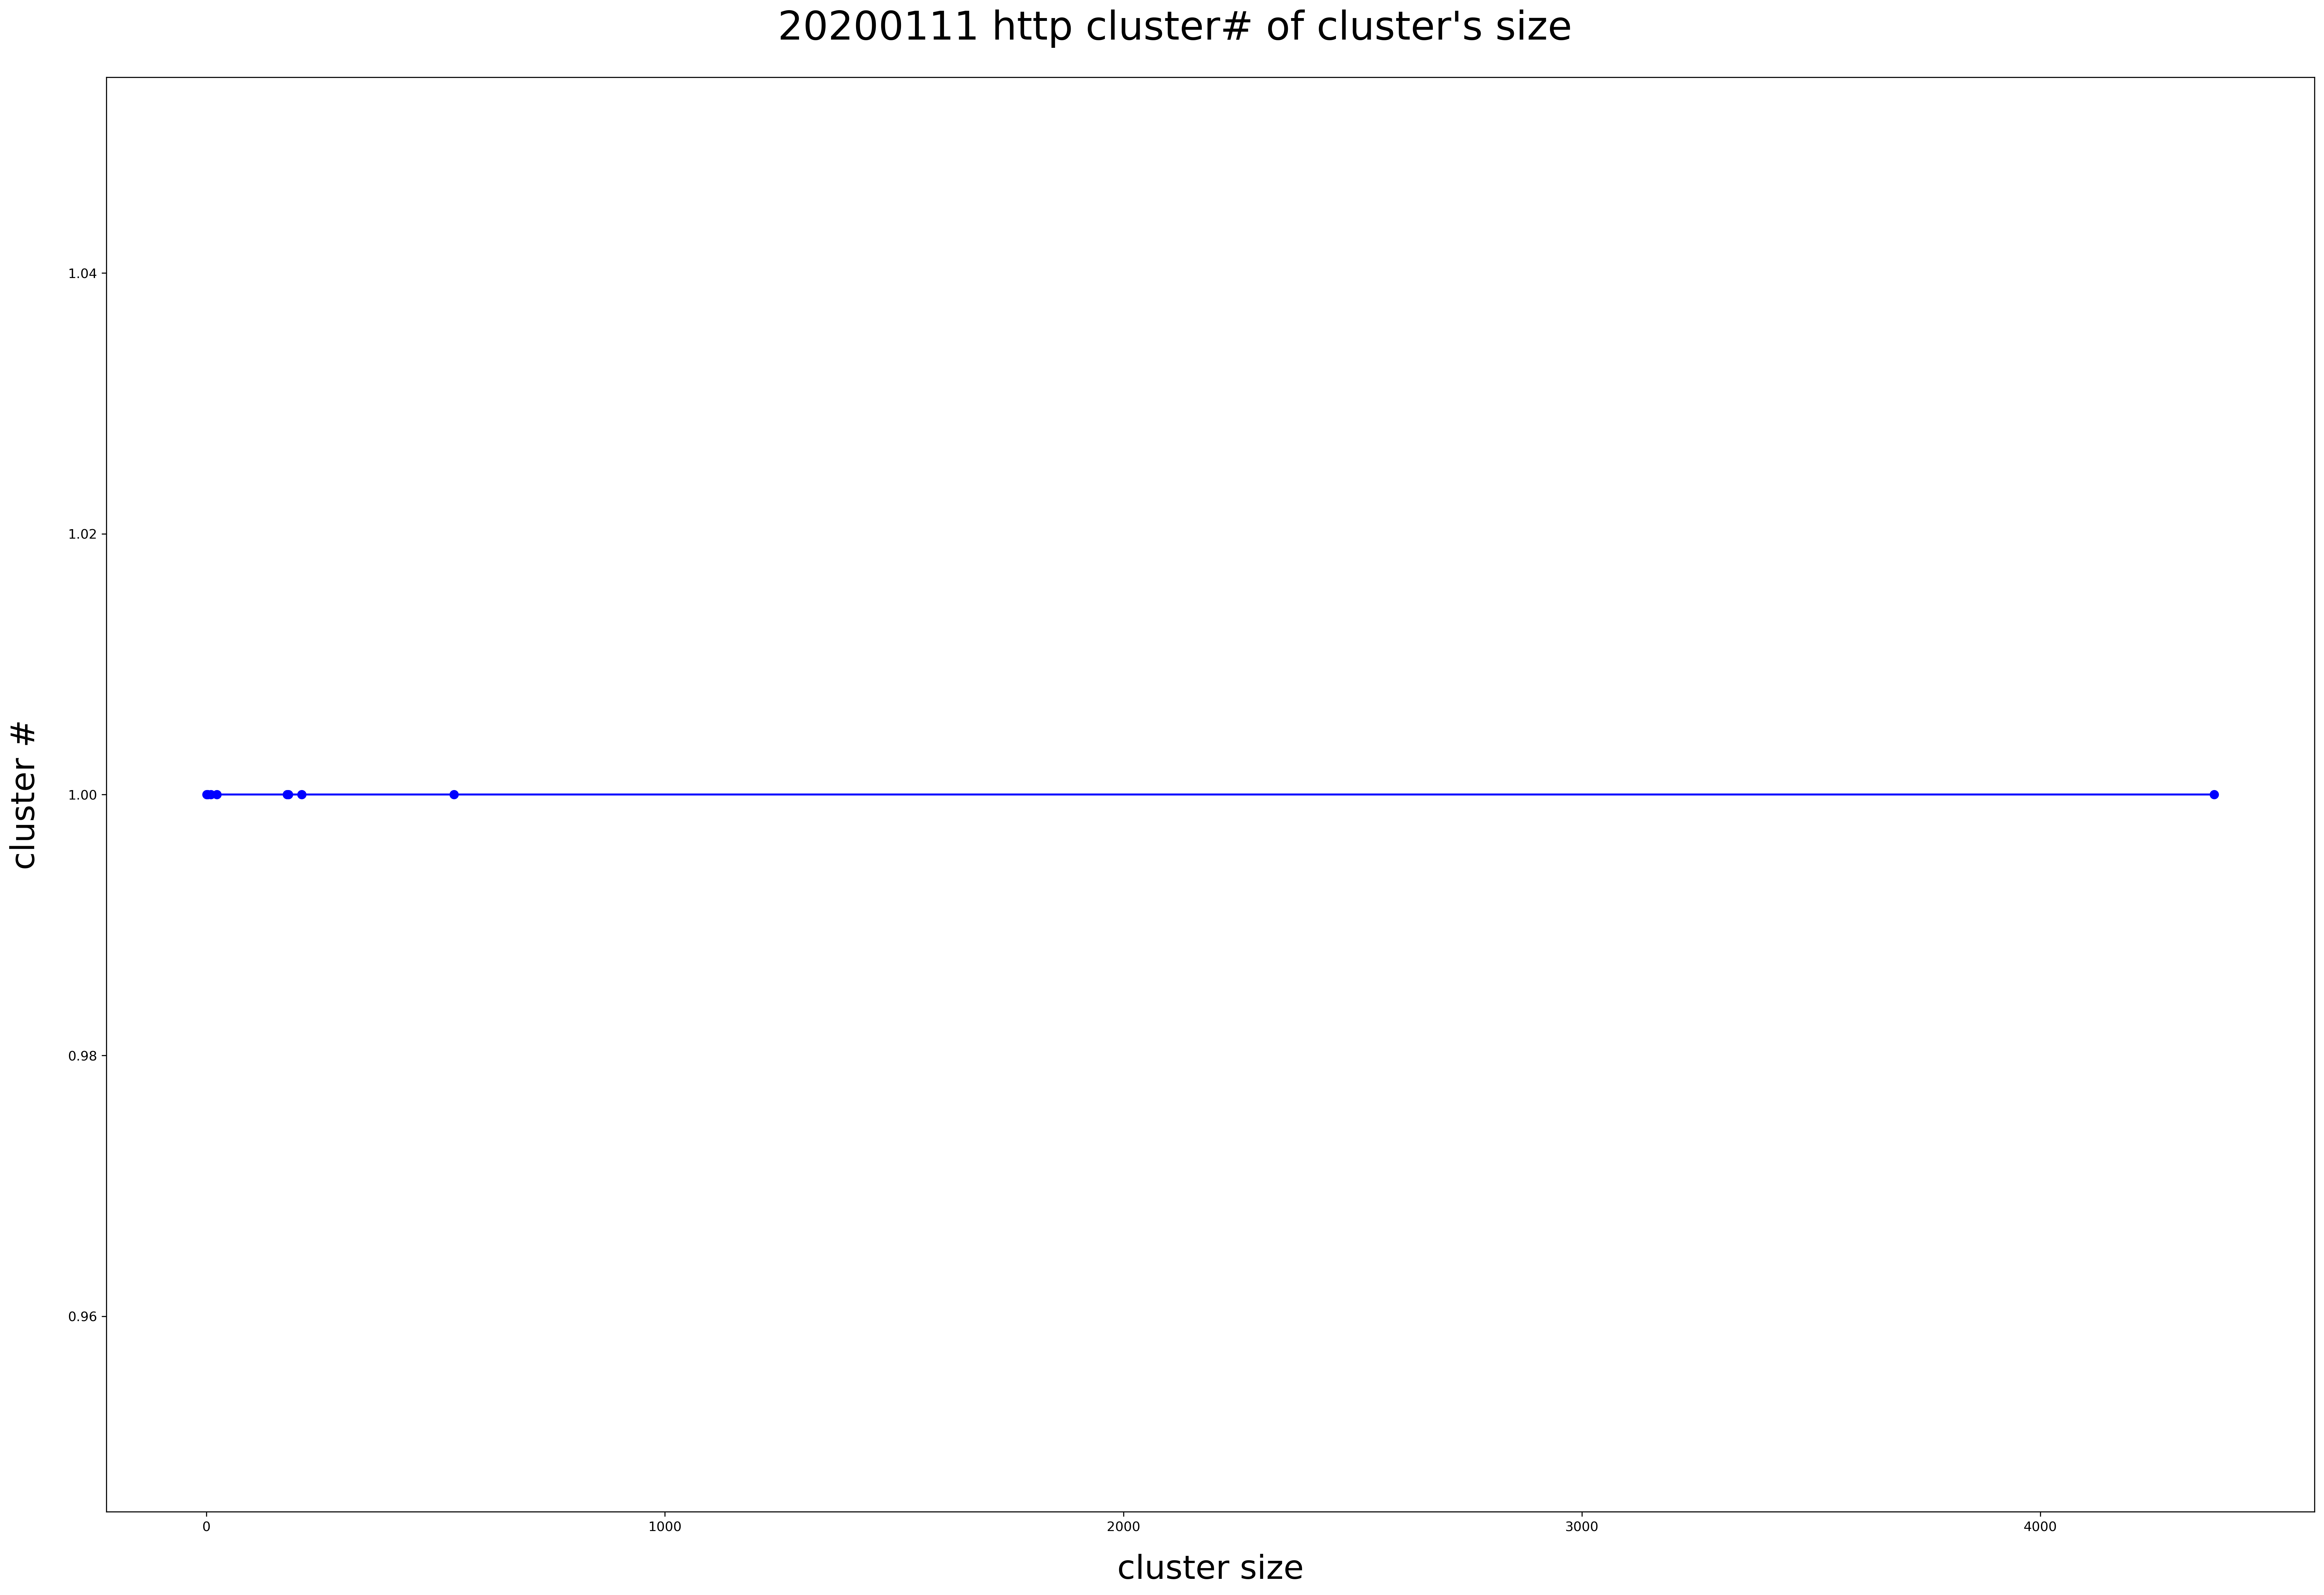

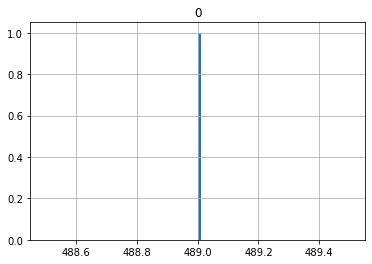

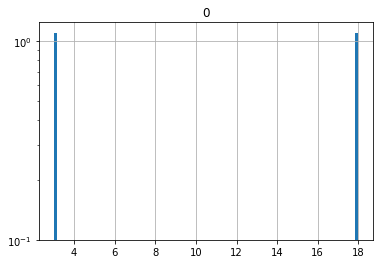

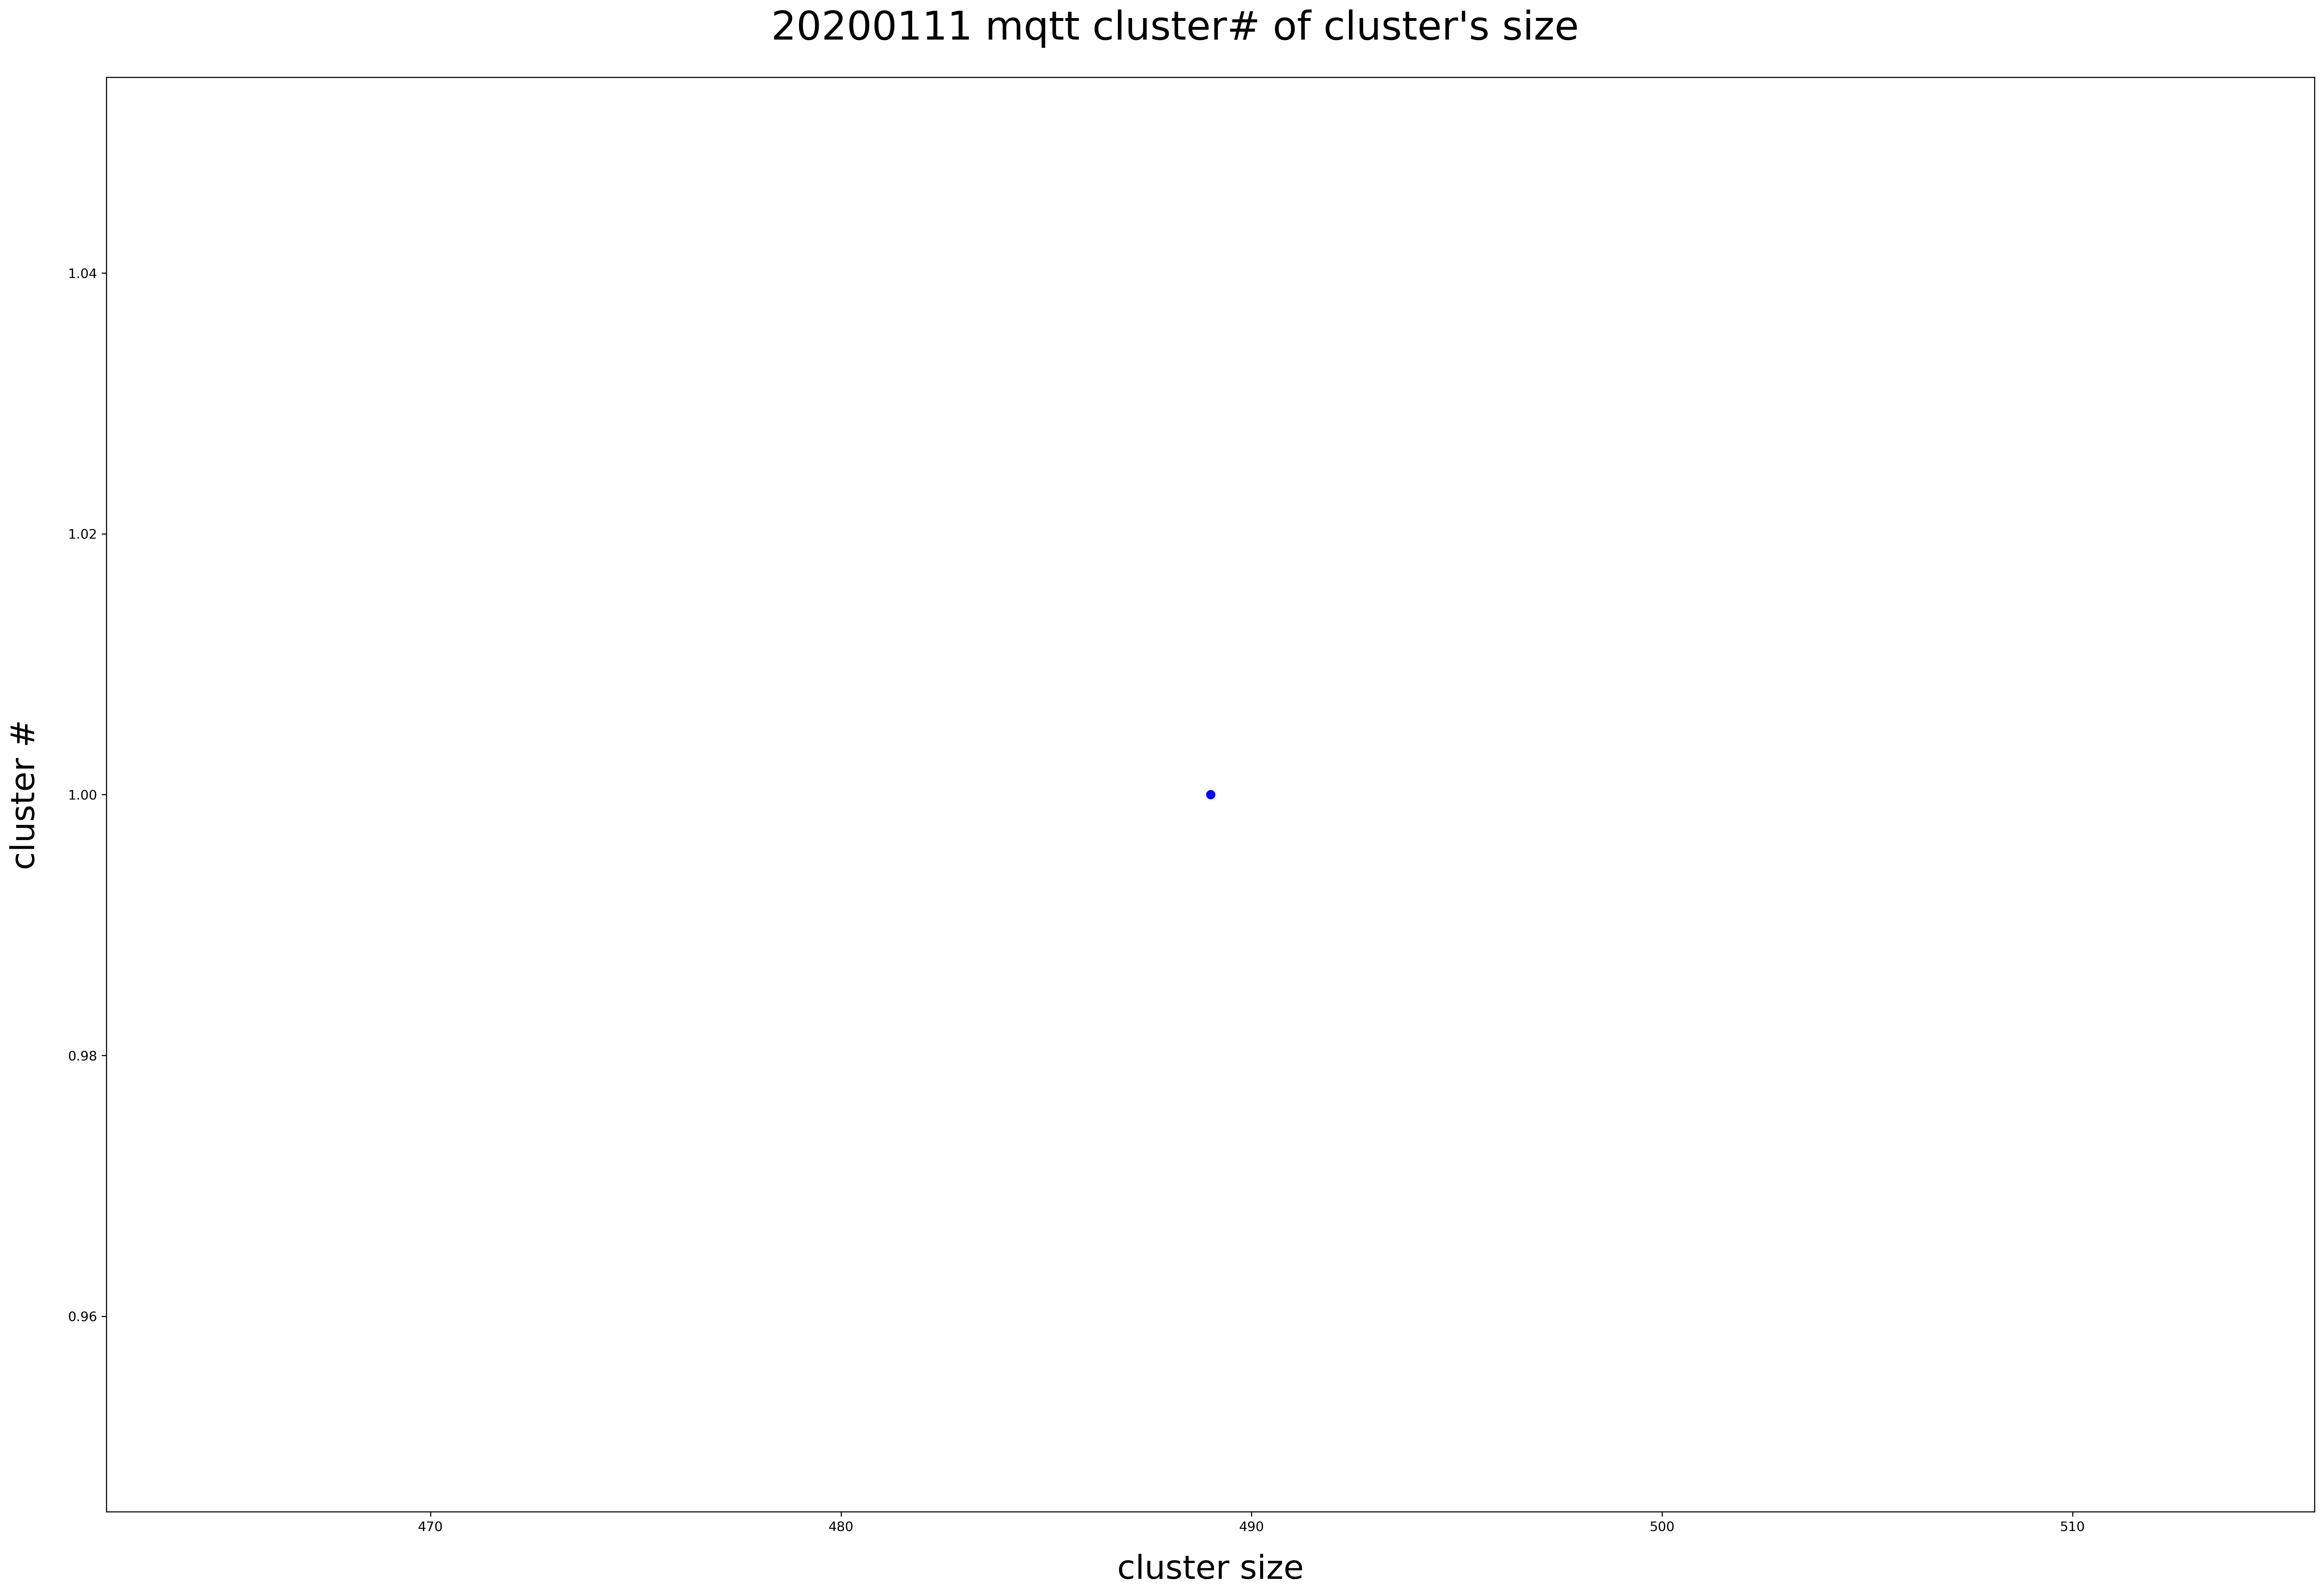

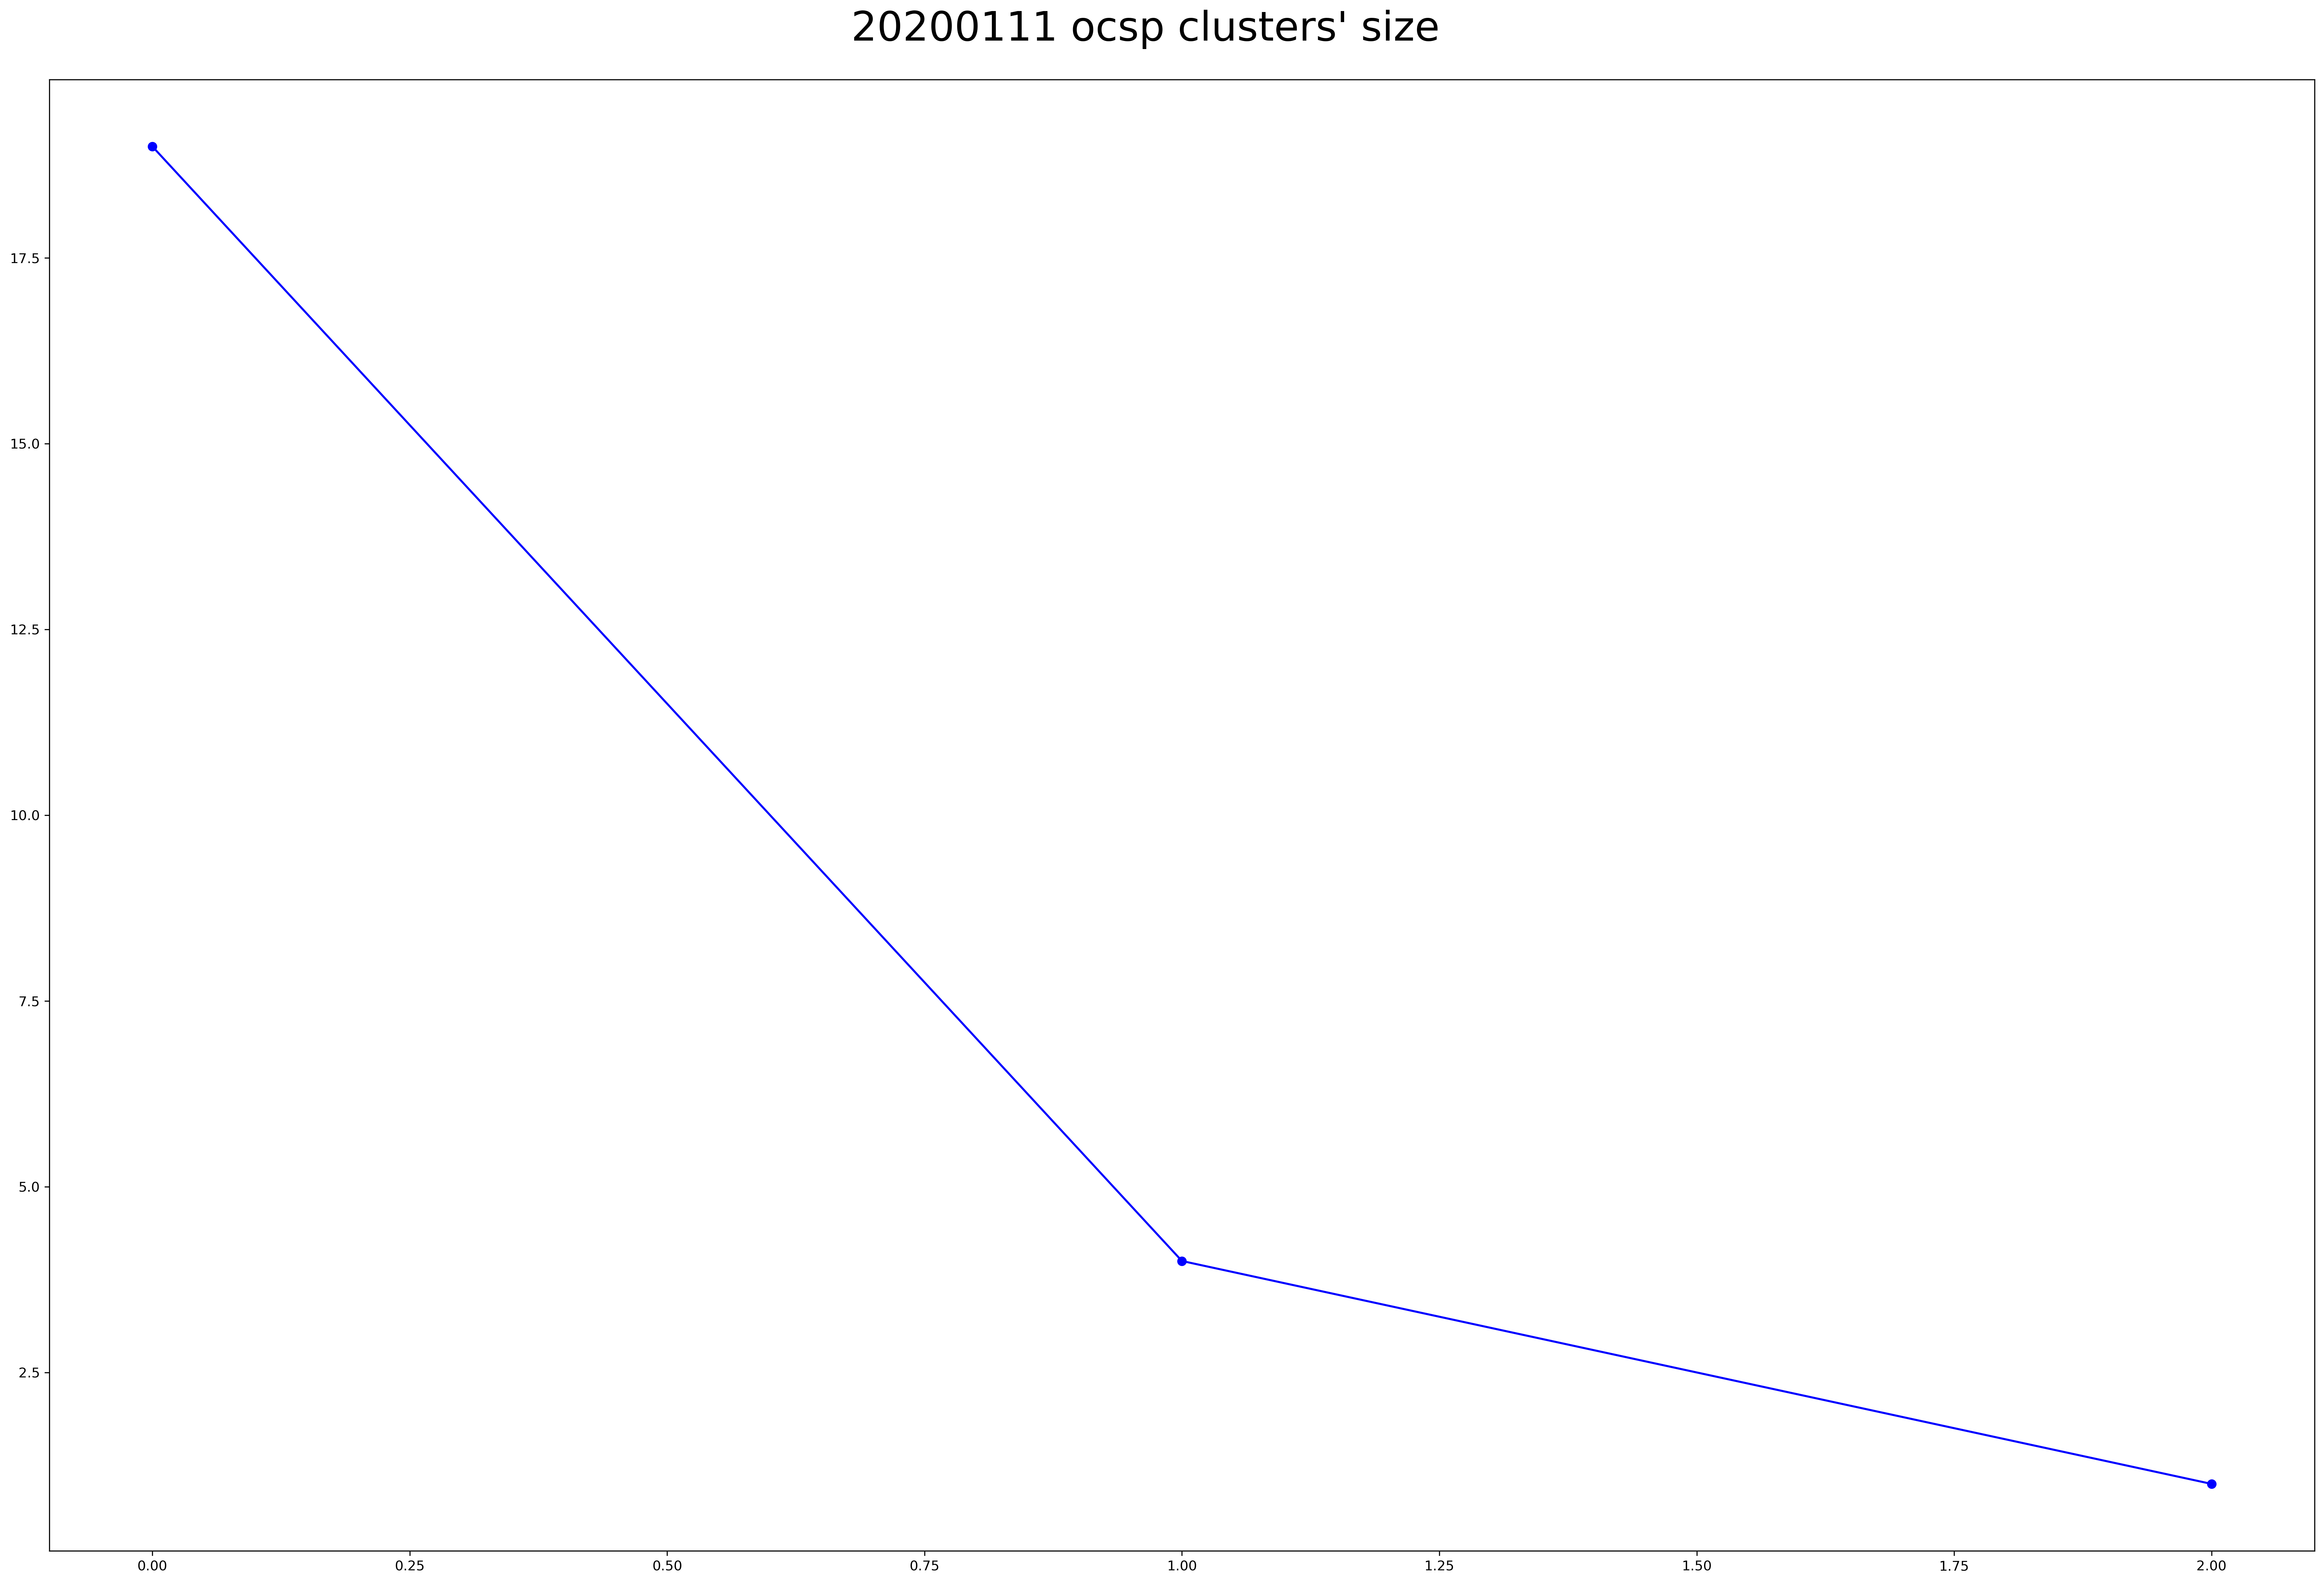

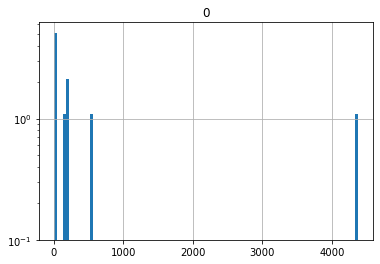

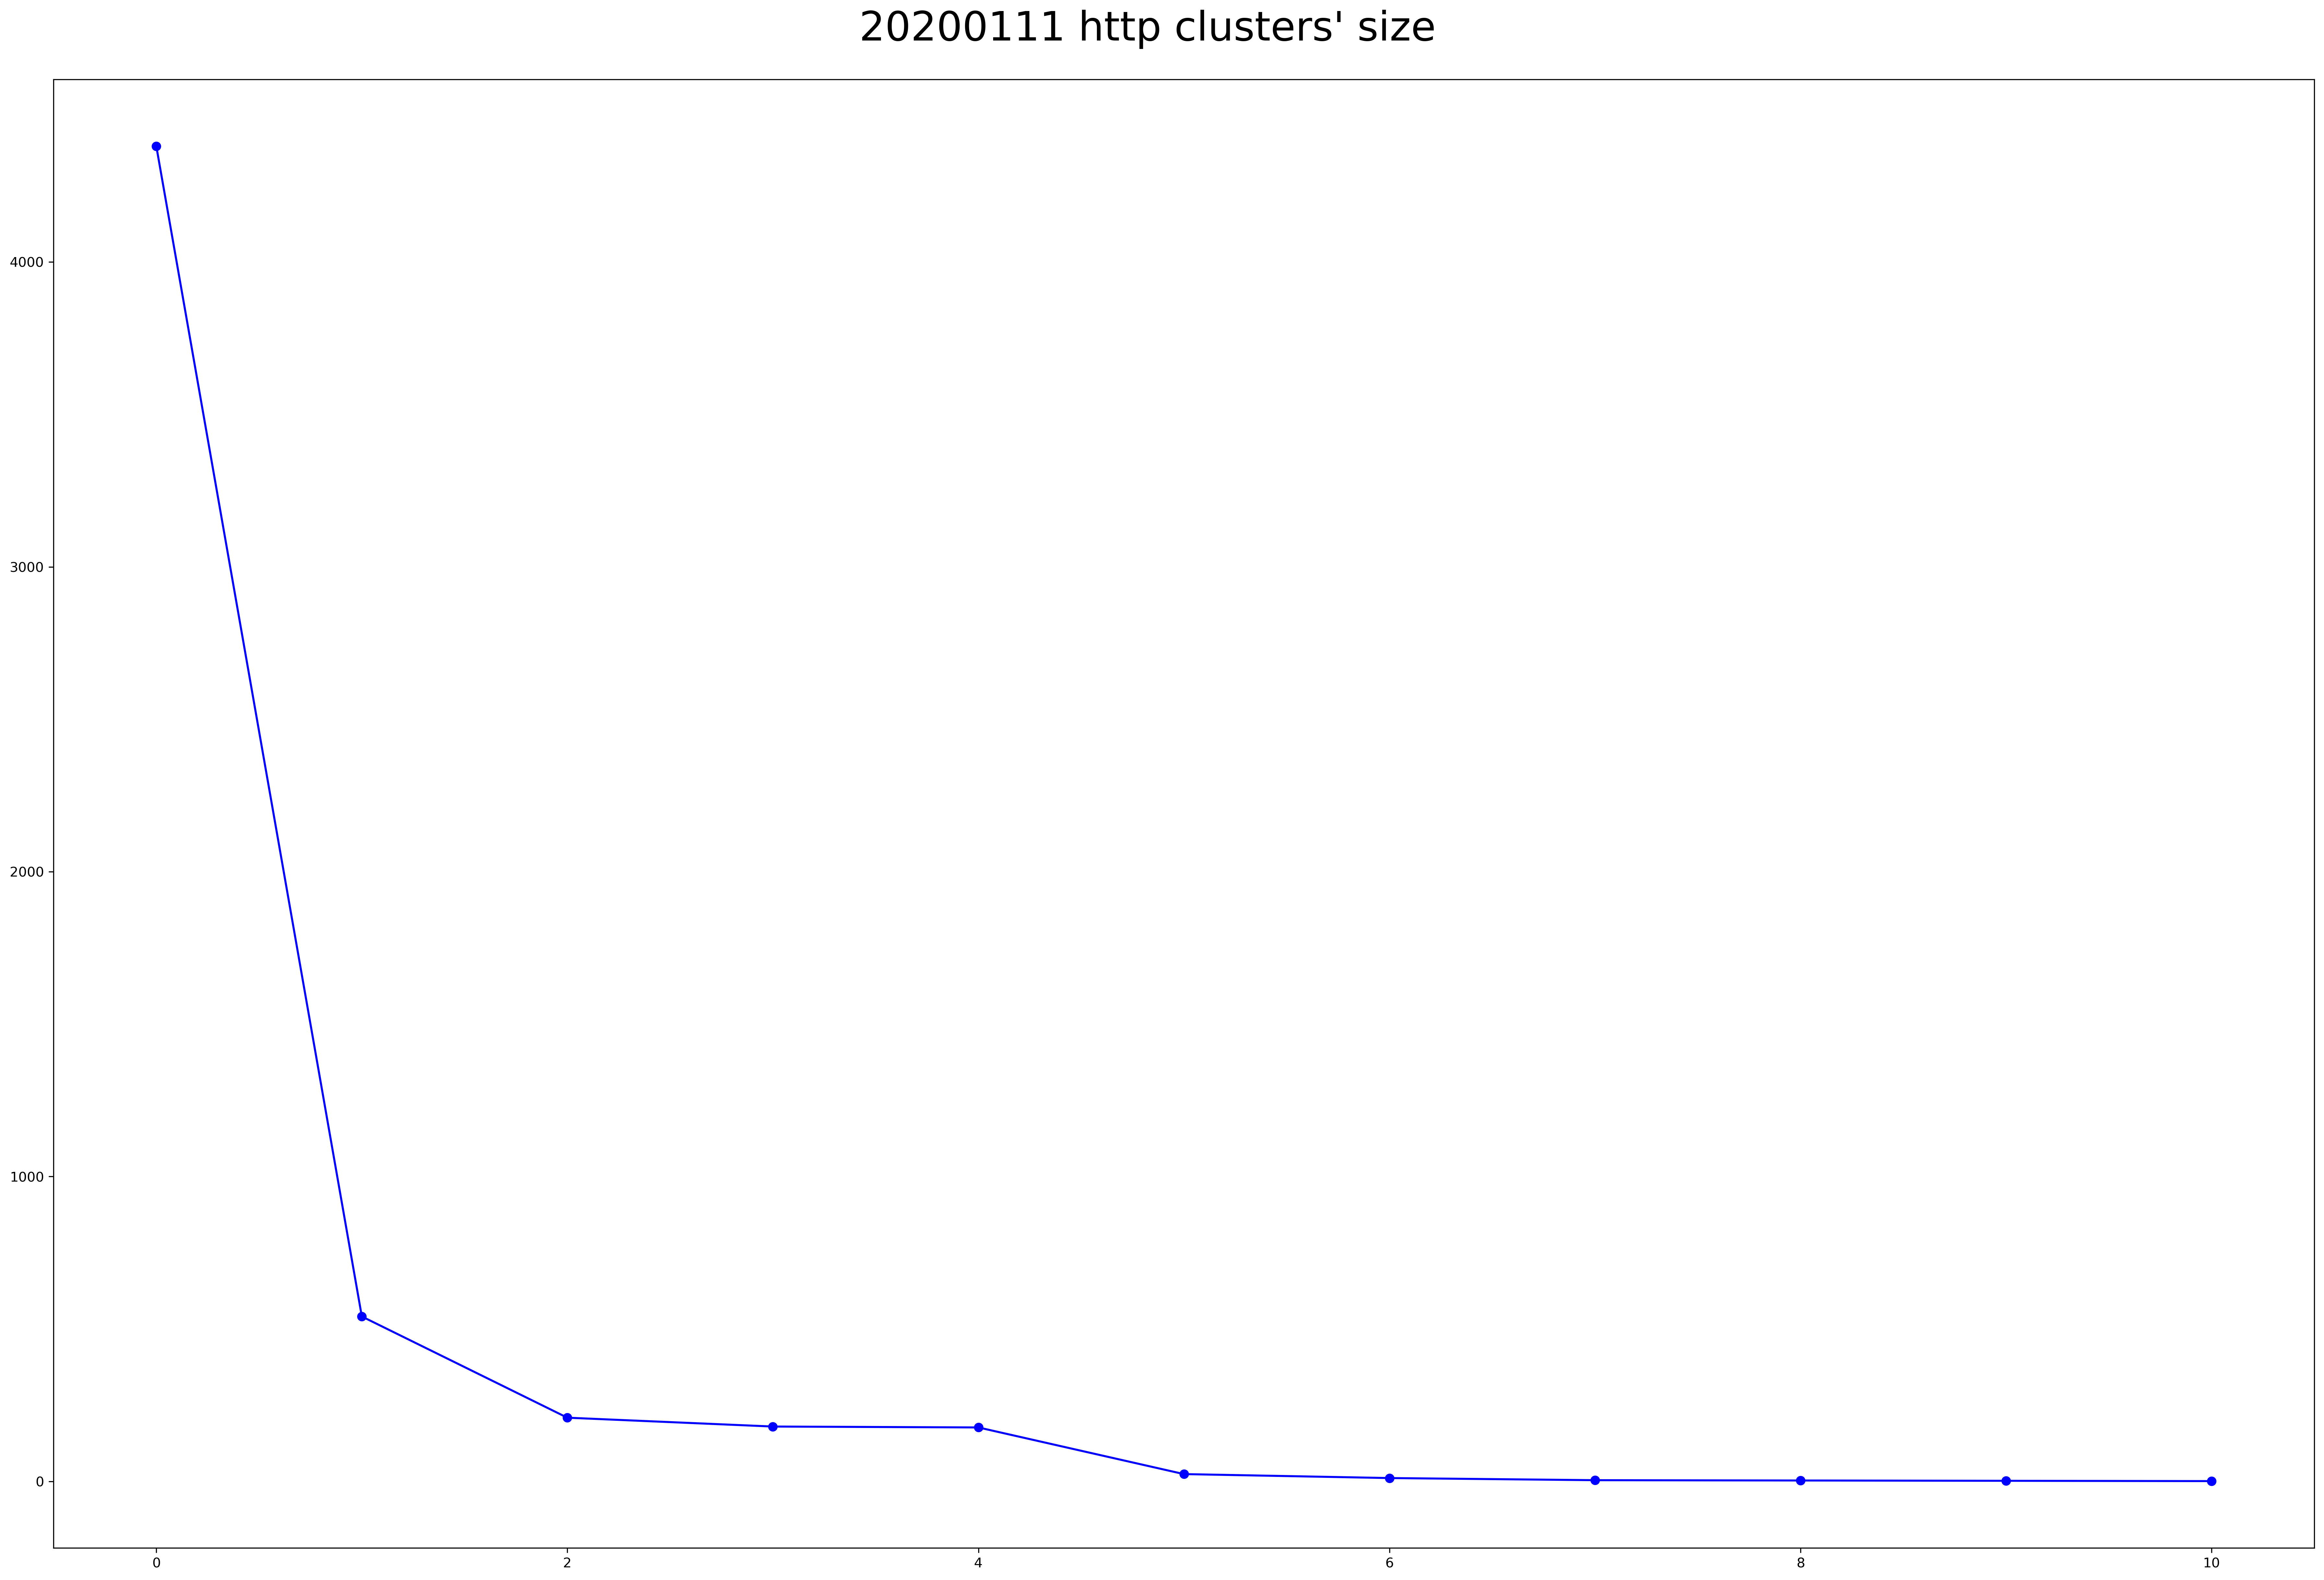

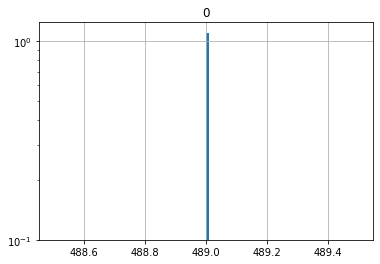

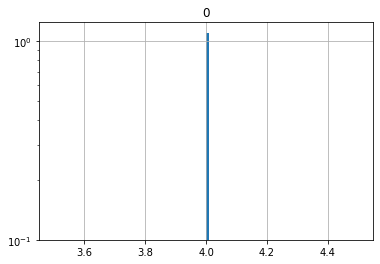

In [39]:
%%time 
#20hrs per day for all protocols

date_li = ['20200101','20200102','20200103','20200104','20200105',
           '20200113','20200114','20200115','20200116','20200117','20200118'] #改
date_li = ['20200111'] #改
# date_li = ['20200109','20200110','20200111','20200112']
for da in date_li:
    print("===Running date:",isp,da,"===")
    dir_path = "/mnt/Raid160TB/pcap_inter/"+str(da[:4])+'_'+str(da[4:6])+'_'+str(da[6:])+"/"+isp+"/intermeidate_data/"
    saved_path = dir_path+"df2_tuples_"+isp+".pkl"
    if path.exists(saved_path):
        df2,pickle_dir,picture_dir = pickle.load(open(saved_path,'rb'))
    else:
        df2,pickle_dir,picture_dir = create_orifinalDF(da) #spark ram: 160G , df ram: 150G  
        if not os.path.exists(dir_path):
            os.makedirs(dir_path,exist_ok=True)    
        pickle.dump(file=open(dir_path+"df2_tuples_"+isp+".pkl",'wb'),protocol=pickle.HIGHEST_PROTOCOL,
                obj=(df2,pickle_dir,picture_dir))
    print(da,'Done df2.')
    argli = []
    for protocol in protocols_need:
        argli.append((protocol,da,df2,pickle_dir,picture_dir))
#     with Pool(processes=10) as pool:
    gc.collect()
    with ThreadPool(3) as pool:
        results = pool.starmap(run_all,argli)
#     print(results.get())
    
#     pool_result = []
# #     pool = Pool(processes=2)
#     pool = ThreadPool(4)
#     for protocol in protocols_need:
# #         r = pool.map_async(run_all,args=(protocol,da,df2,pickle_dir,picture_dir))
#         r = pool.map_async(run_all,(protocol,da,df2,pickle_dir,picture_dir))
#         pool_result.append(r)
#     pool.close()
#     pool.join()
#     for r in pool_result:
#         print('return:',r.get())
#     load_end = time.time() - load_start
#     print("Process Time:", '{:02f}:{:02f}:{:02f}'.format(load_end // 3600, (load_end % 3600 // 60), load_end % 60))
    
#     for protocol in tqdm(protocols_need):
#         run_all(proto=protocol,date=da,df2=df2,pickle_dir=pickle_dir,picture_dir=picture_dir) ##改!!
#         gc.collect()
#     assert len(protocols_need) == len(protocols_tuples)

In [20]:
dir_path

'/mnt/Raid160TB/pcap_inter/2020_01_11/mi/intermeidate_data/'

END

In [ ]:
dir_path = "/mnt/Raid64TB2/intermediateOLD/"+da+"/"
if not os.path.exists(dir_path):
    os.makedirs(dir_path,exist_ok=True)    
pickle.dump(file=open(dir_path+"df2_tuples_"+isp+".pkl",'wb'),protocol=pickle.HIGHEST_PROTOCOL,
        obj=(df2,pickle_dir,picture_dir))

In [ ]:
temp = df2['tcp_i_payload_list'].iloc[0]
sorted(temp,key=itemgetter(1))

In [ ]:
type(df2)

合併三個dict用update來合併以後再通過後面的df function畫圖

In [ ]:
# 大家的pickle_dir都不同0109 0110 0111
# time1 = '10'
# time2 = '02'
# time3 = '30'
time_li = ['06','07','08','09','10','11','12']
# time_li = ['02','10','30']
proto = 'http'
three_dict = {}
for time in time_li:
    path = '/home/antslab/spark_data/pcap_inter/2020_01_'+str(time)+'/中華電信/case_pickles/'+proto+'_upgma_dict_01'+str(time)+'.pkl'
    temp = pickle.load(open(path,'rb'))
    three_dict.update(temp)

    
loner_dict = {}
for k,v in three_dict.items():
    if '_L_' in k:
        loner_dict[k]=v
    if '_S_' in k:
        loner_dict[k] =v

loner_dict

In [ ]:
three_upgma_df = pair_wise_score(three_dict) #改!!
dn,Z = draw_upgma(three_upgma_df,
           picture_dir='/home/antslab/spark_data/pcap_inter/2020_01_06/中華電信/case_pictures/' #改!!
           ,name='0106-0112_upgma') #改!! 0106-0112_upgma

In [ ]:
Z

## 畫跨天protocol大小圖

In [ ]:
trend_dict_time_all = {}
trend_dict_country_all = {}
trend_dict_ip_all = {}
trend_dict_ssdeep_all = {}
def draw_trend_pic(date,proto,pickle_dir,trend_dict_time_all=trend_dict_time_all,trend_dict_country_all=trend_dict_country_all,trend_dict_ip_all=trend_dict_ip_all,trend_dict_ssdeep_all=trend_dict_ssdeep_all):
    '''
    GOAL: output dict to draw trend-circle picture
    
    Return: 4 dict for the same proto for the next day
    '''
    try:
        (proto_df, proto_df_payload,proto_big_dict,proto_loners,proto_score,proto_cluster_score_dict,
                                proto_upgma_dict,stat_df) = pickle.load(open(pickle_dir+str(date)+'_'+str(proto)+'_all.pkl','rb'))
    except ValueError:
        (proto_df, proto_df_payload,proto_big_dict,proto_loners,proto_score,proto_cluster_score_dict,
                                proto_upgma_dict) = pickle.load(open(pickle_dir+str(date)+'_'+str(proto)+'_all.pkl','rb'))
    except FileNotFoundError:
        return trend_dict_time_all,trend_dict_country_all,trend_dict_ip_all,trend_dict_ssdeep_all


    def ssdeep_compare(target_hash,candidate_df):
        '''
        Input1: string of hash
        Input2: dataframe of candidate
        '''
        def compare(candidate_hash):
            if type(candidate_hash) == str:
                return ssdeep.compare(target_hash,candidate_hash)
            else:
                score_li = []
                for c_h in candidate_hash:
                    score_li.append(ssdeep.compare(target_hash,c_h))
                return max(score_li)
        return candidate_df.hash.map(compare)

    trend_dict_time = {}
    trend_dict_country = {}
    trend_dict_ip = {}
    trend_dict_ssdeep = {}
    candidate_df = pd.DataFrame(trend_dict_ssdeep_all.items(),columns=['idx','hash']) #其他已經有的cluster
    for key,value in proto_big_dict.items():
        target = proto_df_payload[proto_df_payload.idx == key]
        target = target.reset_index(drop=True)
        t_len = len(target)
        q2 = int(t_len*0.5)
        t_q2 = target.iloc[q2,-1] #要跟別人比較的cluster hash
        if trend_dict_ssdeep_all == {}: #第一次
            trend_dict_ssdeep[str(date)+"_"+str(key)] = t_q2
            member_li = value[:]
            member_li.append(key)
            select_df = proto_df.loc[member_li]
            time_li = select_df.session_time.tolist()
            trend_dict_time[str(date)+"_"+str(key)] = time_li
            country_li = select_df.country.tolist()
            ip_li = select_df.ip_src.tolist()
            assert len(time_li) == len(country_li) == len(ip_li)
            trend_dict_country[str(date)+"_"+str(key)] = country_li
            trend_dict_ip[str(date)+"_"+str(key)] = ip_li
        else: #後面幾次
            candidate_df['score'] = ssdeep_compare(t_q2,candidate_df) 
            max_score = candidate_df.score.max()
            if max_score < 1: #都沒有相近的
                trend_dict_ssdeep[str(date)+"_"+str(key)] = t_q2
                member_li = value[:]
                member_li.append(key)
                select_df = proto_df.loc[member_li]
                time_li = select_df.session_time.tolist()
                trend_dict_time[str(date)+"_"+str(key)] = time_li
                country_li = select_df.country.tolist()
                ip_li = select_df.ip_src.tolist()
                assert len(time_li) == len(country_li) == len(ip_li)
                trend_dict_country[str(date)+"_"+str(key)] = country_li
                trend_dict_ip[str(date)+"_"+str(key)] = ip_li
            elif max_score>0: #有相近的合併到原本的dict
                try:
                    combine_id = candidate_df[candidate_df.score == max_score].idx.tolist()[0]
                except:
                    print( candidate_df,max_score,target)
                ori_ssdeep_list = trend_dict_ssdeep_all[combine_id][:]
                if type(ori_ssdeep_list) == str:
                    ori_ssdeep_list = [ori_ssdeep_list] #之前只有一個ssdeep hash
                ori_time_list = trend_dict_time_all[combine_id][:]
                ori_country_list = trend_dict_country_all[combine_id][:]
                ori_ip_list = trend_dict_ip_all[combine_id][:]
                member_li = value[:]
                member_li.append(key)
                select_df = proto_df.loc[member_li]
                time_li = select_df.session_time.tolist()
                ori_time_list.extend(time_li)
                country_li = select_df.country.tolist()
                ip_li = select_df.ip_src.tolist()
                ori_country_list.extend(country_li)
                ori_ip_list.extend(ip_li)
                ori_ssdeep_list.append(t_q2) #我合併進入別人的群，所以把我群的key hash也加入
                assert len(ori_time_list) == len(ori_country_list) == len(ori_ip_list)
                trend_dict_time_all[combine_id] = ori_time_list
                trend_dict_country_all[combine_id] = ori_country_list
                trend_dict_ip_all[combine_id] = ori_ip_list
                trend_dict_ssdeep_all[combine_id] = ori_ssdeep_list
            else:
                print(max_score)
#         break #debug
    trend_dict_time_all.update(trend_dict_time)
    trend_dict_country_all.update(trend_dict_country)
    trend_dict_ip_all.update(trend_dict_ip)
    trend_dict_ssdeep_all.update(trend_dict_ssdeep)
    return trend_dict_time_all,trend_dict_country_all,trend_dict_ip_all,trend_dict_ssdeep_all

In [ ]:
def sort_li(time_li, country_li):
    '''
    GOAL: sort by time (align with time's order)
    Return: list
    '''
    sort_country_li = [x for _,x in sorted(zip(time_li,country_li))]
    return sort_country_li

In [ ]:

# date_li = ["0110","0130","0102"]
date_li = ["0102","0106","0107","0108","0109","0110","0111","0112","0130"] #,"0102","0130"
proto_li = ['tds','http','smb','telnet','ftp','smtp','mysql','ssh','rpc','imap','pop','sip']
for proto in tqdm(proto_li):
    trend_dict_time_all = {}
    trend_dict_country_all = {}
    trend_dict_ip_all = {}
    trend_dict_ssdeep_all = {}
    for date in date_li:
        pickle_dir = '/home/antslab/spark_data/pcap_inter/2020_01_'+str(date[-2:])+'/中華電信/case_pickles/'
        trend_dict_time_all,trend_dict_country_all,trend_dict_ip_all,trend_dict_ssdeep_all = draw_trend_pic(date,proto,
                                                                                          pickle_dir,trend_dict_time_all,trend_dict_country_all,trend_dict_ip_all,trend_dict_ssdeep_all)
    trend_dict_time_all = {k: v for k, v in sorted(trend_dict_time_all.items(), key=lambda item: len(item[1]),reverse=True)}
    time_df = pd.DataFrame(trend_dict_time_all.items(),columns=['idx','timestamp'])
    trend_dict_country_all = {k: v for k, v in sorted(trend_dict_country_all.items(), key=lambda item: len(item[1]),reverse=True)}
    country_df = pd.DataFrame(trend_dict_country_all.items(),columns=['idx','country'])
    trend_dict_ip_all = {k: v for k, v in sorted(trend_dict_ip_all.items(), key=lambda item: len(item[1]),reverse=True)}
    ip_df =  pd.DataFrame(trend_dict_ip_all.items(),columns=['idx','src_ip'])
    ssdeep_df = pd.DataFrame(trend_dict_ssdeep_all.items(),columns=['idx','ssdeep'])
    all_df = pd.merge(time_df,country_df,on='idx')
    all_df =  pd.merge(all_df,ip_df,on='idx')
    all_df = pd.merge(all_df,ssdeep_df,on='idx')
    all_df['country'] = all_df.apply(lambda x: sort_li(x.timestamp, x.country), axis=1)
    all_df['src_ip'] = all_df.apply(lambda x: sort_li(x.timestamp, x.src_ip), axis=1)
    all_df['timestamp'] = all_df.timestamp.map(sorted)
    file_name = "_".join(sorted(date_li))
    pickle.dump(obj=all_df,
                file=open('/home/antslab/spark_data/pcap_inter/2020_01_'+str(min(date_li)[-2:])+'/中華電信/case_pickles/'+proto+'_trend_df_'+file_name+'.pkl','wb'))

In [ ]:
proto = 'http'
date_li = ["0102","0106","0107","0108","0109","0110","0111","0112","0130"] #,"0102","0130"
file_name = "_".join(sorted(date_li))

http_df = pickle.load(open('/home/antslab/spark_data/pcap_inter/2020_01_'+str(min(date_li)[-2:])+'/中華電信/case_pickles/'+proto+'_trend_df_'+file_name+'.pkl','rb'))
http_df

In [ ]:
#輸出cluster之key session的time list
wireshark_li = http_df.idx.tolist() #.head(15)前15大cluster #改!proto
wireshark_rank = []
for i,v in enumerate(wireshark_li):
    wireshark_rank.append(i+1)
wireshark_rank = [x for _,x in sorted(zip(wireshark_li,wireshark_rank))]
wireshark_li = sorted(wireshark_li)

save_path_li = []
now_date = '00' #現在正在處理的日期
for i,wireshark in tqdm(zip(wireshark_rank,wireshark_li)):
    date = wireshark.split('_')[0] #該cluster key的同月份日期
    if date!= now_date: #新日期才要重讀
        now_date = date
        
        pickle_dir = '/home/antslab/spark_data/pcap_inter/2020_01_'+str(date[-2:])+'/中華電信/case_pickles/'
        try:
            (proto_df, proto_df_payload,proto_big_dict,proto_loners,proto_score,proto_cluster_score_dict,
                                    proto_upgma_dict,stat_df) = pickle.load(open(pickle_dir+str(date)+'_'+str(proto)+'_all.pkl','rb'))
        except ValueError:
            (proto_df, proto_df_payload,proto_big_dict,proto_loners,proto_score,proto_cluster_score_dict,
                                    proto_upgma_dict) = pickle.load(open(pickle_dir+str(date)+'_'+str(proto)+'_all.pkl','rb'))
        except FileNotFoundError:
            continue
    idx = wireshark.split('_')[-1] #該cluster在該日期該proto的df中的index
    #     else:
    try:
        time_list = proto_df.loc[int(idx),'session_time_list'].tolist()
    except AttributeError:
        time_list = proto_df.loc[int(idx),'session_time_list']
    timelist_path = pickle_dir+'timelist_'+proto+'_large#'+str(i)+'_clusterID#'+str(idx)+'.pkl'
    pickle.dump(file=open(timelist_path,'wb'),obj=time_list)
    print(wireshark,'save in:',timelist_path)
    save_path_li.append(timelist_path)

first_date = wireshark_li[0].split('_')[0][-2:]
save_path = '/home/antslab/spark_data/pcap_inter/2020_01_'+first_date+'/中華電信/case_pickles/'+proto+'_clusterKey_timelist_paths.pkl'
pickle.dump(file=open(save_path,'wb'),obj=save_path_li)  
print('all paths in:',save_path)

In [ ]:
def count_distinct_number(li):
    return len(set(li))

In [ ]:
http_df['ip_num'] = http_df.src_ip.map(count_distinct_number)
http_df['ip_num']

小群關聯
* L、S
* src_ip

In [ ]:
loner_protocol_dict = {}
loner_time_dict = {}
date_li = ["0110","0111","0109","0112","0108","0107","0106"] #,"0102","0130"
proto_li = ['http','smb','telnet','ftp','smtp','mysql','ssh','rpc','imap','pop','sip']
# for proto in tqdm(proto_li):
for date in date_li:
    pickle_dir = '/home/antslab/spark_data/pcap_inter/2020_01_'+str(date[-2:])+'/中華電信/case_pickles/'
    try:
        (proto_df, proto_df_payload,proto_big_dict,proto_loners,proto_score,proto_cluster_score_dict,
                                proto_upgma_dict,stat_df) = pickle.load(open(pickle_dir+str(date)+'_'+str(proto)+'_all.pkl','rb'))
    except ValueError:
        (proto_df, proto_df_payload,proto_big_dict,proto_loners,proto_score,proto_cluster_score_dict,
                                proto_upgma_dict) = pickle.load(open(pickle_dir+str(date)+'_'+str(proto)+'_all.pkl','rb'))
    except FileNotFoundError:
        continue
    for k,v in proto_upgma_dict.items():
        if '_L_' not in k: #只拿Loner來做關聯
            continue
        lonerInfo = k.split('_')
        loner_ip = lonerInfo[-1]
        loner_counry = lonerInfo[-3]
        loner_domain = lonerInfo[-2]
        for d in date_li:
            in_file = '/home/antslab/data_hdd4t/pcap_process/pcap_spark/2020_01_'+str(d[-2:])+'/中華電信/parquet/2020_01_'+str(date[-2:])+'_session_v7-2_hashpayload_time_size.parquet' #改!!
            df_loner = ks.read_parquet(in_file)
            ip_df = df_loner[df_loner.ip_src == loner_ip]
            ip_df = ip_df.to_pandas()
            try:
                ori_loner_time_li = loner_time_dict['L_'+loner_counry+'_'+loner_domain+'_'+loner_ip][:]
                ori_loner_protocol_li = loner_protocol_dict['L_'+loner_counry+'_'+loner_domain+'_'+loner_ip][:]
                ori_loner_time_li.extend(ip_df.session_time.tolist())
                ori_loner_protocol_li.extend(ip_df.frame_o_max_protocols.tolist())
                loner_time_dict['L_'+loner_counry+'_'+loner_domain+'_'+loner_ip] = ori_loner_time_li
                loner_protocol_dict['L_'+loner_counry+'_'+loner_domain+'_'+loner_ip] = ori_loner_protocol_li
            except KeyError:
                loner_time_dict['L_'+loner_counry+'_'+loner_domain+'_'+loner_ip] = ip_df.session_time.tolist()
                loner_protocol_dict['L_'+loner_counry+'_'+loner_domain+'_'+loner_ip] = ip_df.frame_o_max_protocols.tolist()
    break #debug
#     break #debug

In [ ]:
proto_upgma_dict

In [ ]:
in_file = '/home/antslab/data_hdd4t/pcap_process/pcap_spark/2020_01_10/中華電信/parquet/2020_01_10_session_v7-2_hashpayload_time_size.parquet'
df = ks.read_parquet(in_file)
ip_df = df[df.ip_src == '200.255.122.170']
ip_df = ip_df.to_pandas()
gc.collect()
ip_df['frame_i_max_protocols'].unique()

In [ ]:
ip_df

畫distribution
* 針對某單一case進行

In [ ]:
def case_study(idx,payload_df):
    '''
    idx: which index is the dataframe's target?
    payload_df: protocol payload dataframe (packet-based)
    下面有一些參數可以改 (line19~23、27註解處)
    
    Return: Big dict
    '''
    big_dict = {}
    idx = int(idx)
    target = payload_df[payload_df.idx == idx]
    target = target.reset_index(drop=True)
    t_len = len(target)
    t_q1 = target.iloc[int(t_len*0.25),-1]
    t_q2 = target.iloc[int(t_len*0.5),-1]
    t_q3 = target.iloc[int(t_len*0.75),-1]
    candidate = payload_df[payload_df.idx != idx]
    candidate['idx'] = candidate.idx.astype(str)
    candidate_q1 = candidate[candidate['size']==target.iloc[int(t_len*0.25),-2]] #是否要match: match改成== 不match改成!=
    candidate['q1'] = ssdeep_compare(t_q1,candidate_q1)
    candidate_q2 = candidate[candidate['size']==target.iloc[int(t_len*0.5),-2]] # == or != (score=0)
    candidate['q2'] = ssdeep_compare(t_q2,candidate_q2)
    candidate_q3 = candidate[candidate['size']==target.iloc[int(t_len*0.75),-2]] #要找不像的時候要改成!=
    candidate['q3'] = ssdeep_compare(t_q3,candidate_q3)
    candidate = candidate.drop(['size','hash'],axis=1)
    candidate['score'] = candidate.max(axis=1)
    candidate = candidate[candidate.score>0] #相似度分數，數字越小速度愈快、數字越大越多群。要抓出幾分的人> == <
    candidate['idx'] = candidate.idx.astype(int)
    idx_li = candidate.idx.tolist()
    if len(idx_li)>0:
        big_dict[idx] = idx_li
    # len(big_dict.keys())
    print("所有該protocol與所給定之target的分數種類:",candidate.score.unique())
    print("總session數量:",len(big_dict[idx]))
    print("分數的分布:",candidate.score.value_counts().sort_index())
    print("分數的分布圖:",candidate.score.hist(bins=25))
    return big_dict, candidate